# Project Overview

## Objective

## Performance Criteria

## Hypothesis

## Assumptions & Exclusions

# Setup

In [1]:
import pandas as pd
import numpy as np
import os
import scikitplot as skplt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from future_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPRegressor

# To serialise models
from sklearn.externals import joblib

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

pd.set_option('display.max_columns', 60)

import seaborn as sns
sns.set(font_scale = 2)
sns.set()

# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


PROCESSED_PATH = os.path.join(PROJECT_ROOT_DIR, "processed")
def save_processed(df, filename, extension="csv"):
    if not os.path.isdir(PROCESSED_PATH):
        os.makedirs(PROCESSED_PATH)
    path = os.path.join(PROCESSED_PATH, filename + "." + extension)
    print("Saving processed dataset", filename)
    df.to_csv(path, index=False)
    
SUBMISSIONS_PATH = os.path.join(PROJECT_ROOT_DIR, "submissions")
def save_submission(df, filename, extension="csv"):
    if not os.path.isdir(SUBMISSIONS_PATH):
        os.makedirs(SUBMISSIONS_PATH)
    path = os.path.join(SUBMISSIONS_PATH, filename + "." + extension)
    print("Saving submission", filename)
    df.to_csv(path, index=False)

MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
def save_model(model, filename):
    if not os.path.isdir(MODELS_PATH):
        os.makedirs(MODELS_PATH)
    path = os.path.join(MODELS_PATH, filename + "." + "pkl")
    print("Saving model", filename)
    joblib.dump(model, path)
    
# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

# Get Data

In [2]:
import os
import tarfile
from six.moves import urllib

def fetch_data(base_url, file_name, remote_sub_dir=None, file_ext="csv", base_local_path = "raw", local_store_sub_dir=None):
    '''
    Downloads file_name.file_ext from base_url & optional remote_sub_dir and stores it in relative base_local_path & 
    optional local_store_sub_dir. If file is a tarball, it will be extracted as well. 
    
    Issues: doesn't work with .csv.gz files
    '''
    if remote_sub_dir is not None:
        download_url = base_url + remote_sub_dir + file_name + "." + file_ext
    else:
        download_url = base_url + file_name + "." + file_ext
    
    if not os.path.isdir(base_local_path):
         os.makedirs(base_local_path)
            
    if local_store_sub_dir is not None:
        local_path = os.path.join(base_local_path, local_store_sub_dir)
        if not os.path.isdir(local_path):
            os.makedirs(local_path)
    else:
        local_path = os.path.join(base_local_path)
    
    
    full_file_name = file_name + "." + file_ext
    file_path = os.path.join(local_path, full_file_name)
    
    print("Downloading file:", full_file_name)
    urllib.request.urlretrieve(download_url, file_path)
    
    if file_ext in ["tgz", "tar", "gz", "tar.gz"]:
        data_tgz = tarfile.open(file_path)
        data_tgz.extractall(path=local_path)
        data_tgz.close()

In [3]:
filenames = ["train", "test", "sample_submission", "data_description"]
extensions = ["csv", "csv", "csv", "txt"]

for file, ext in zip(filenames, extensions):
    fetch_data(base_url = "https://raw.githubusercontent.com/dorond/kaggle-house-prices-prediction/master/", 
           file_name = file, 
           remote_sub_dir="raw/", 
           file_ext=ext)

In [4]:
def load_data(base_path, file, sub_dir=None, ext="csv", encoding=None):
    filename = file + "." + ext
    if sub_dir is not None:
        csv_path = os.path.join(base_path, sub_dir, filename)
    else:
        csv_path = os.path.join(base_path, filename)
    return pd.read_csv(csv_path)

In [5]:
base_path = "raw/"
train = load_data(base_path, "train")
test = load_data(base_path, "test")

# Explore the Data

In [6]:
train["source"] = "train"
test["source"] = "test"
data = pd.concat([train, test], ignore_index=True, sort=False)
print (train.shape, test.shape, data.shape)

(1460, 82) (1459, 81) (2919, 82)


First let's take a look at the type of data we have. 

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,...,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,...,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,...,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,...,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,...,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,train


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [9]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
missing_values_table(train)

Your selected dataframe has 82 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5
GarageQual,81,5.5


Clearly there are a lot of missing values, however in the case of categorical variables `PoolQC`, `MiscFeature`, `Alley`, `Fence` and `FireplaceQu`, the data dictionary indicates that there is an option to have `No Pool` or `No Fireplace` which was given by the code `NA`. Pandas considered this as `nan` hence their high missing count. Rather than remove these columns or rows, we should apply the appropriate level (`No Pool` etc.) so that we can make use of this info later. All the missing values from the Garage, Basement and Masonary related fields are similar, i.e. there is `No Garage`, `No Basement` and `No Masenory`

Let's take a look at the distributions of our numerical variables.

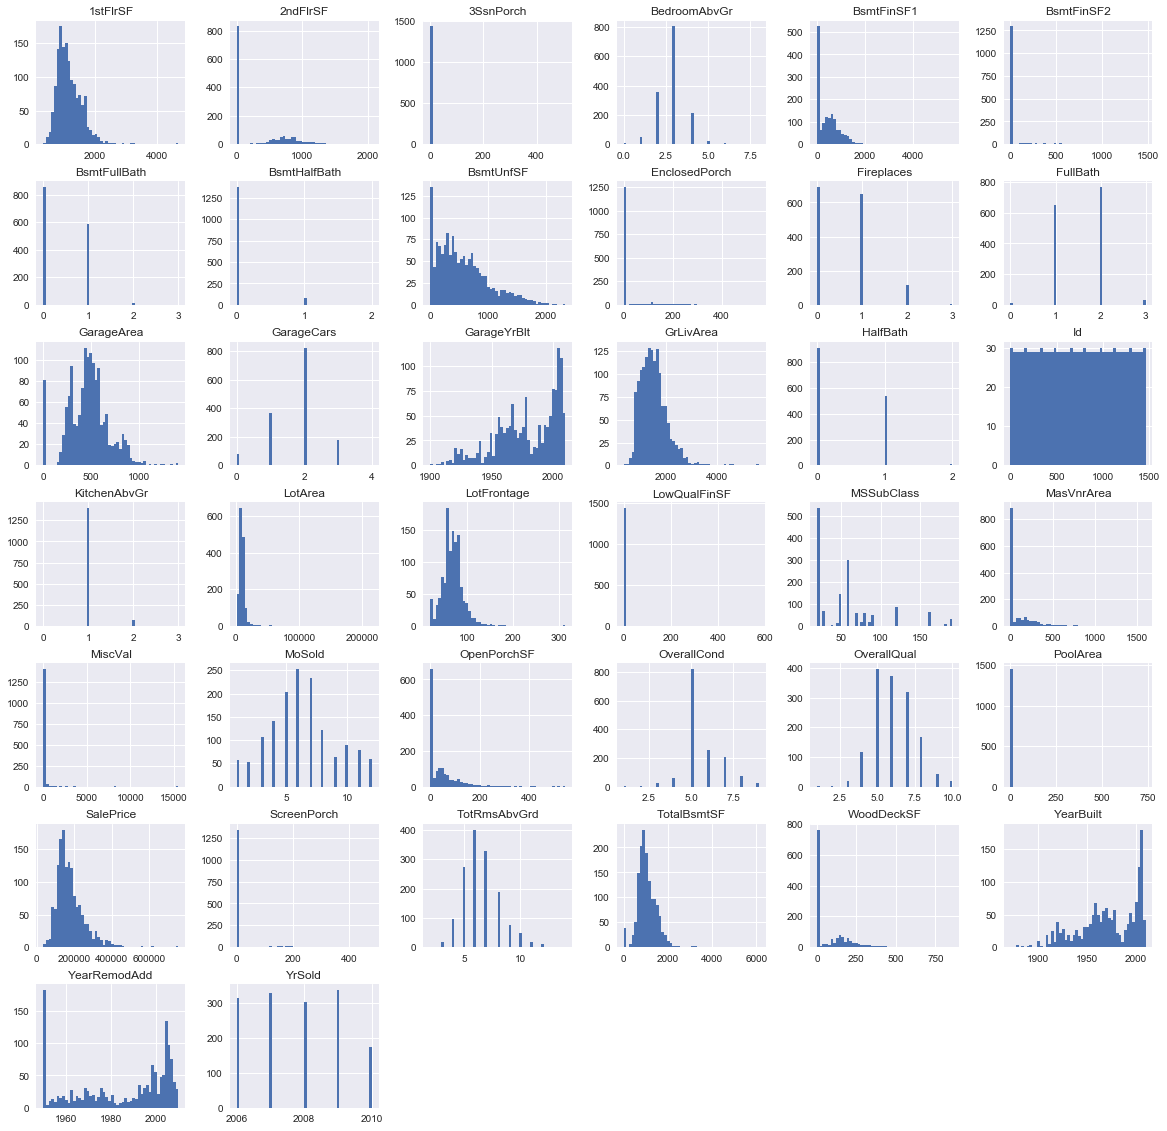

In [11]:
train.hist(bins=50, figsize=(20, 20))
plt.show()

- A lot of variables have a high density of values around 0, these are the cases where for example, if they don't have a garage, then `GarageArea` will be specified as 0. For some variables, it might be useful to create bins rather than rely on the raw values. 
- A lot of properties were built post 2000 indicating that there was a lot of growth in the area at that time. 
- `YearRemodAdd` value should match the `YearBuilt` values if no buildig remods have been applied, however we see that a lot of remods have been specified in the first year of the data. New features will be created where we can see the number of years since the building was built, remodelled and sold. This will correct these errors and then we can remove these Year variables. 
- A number of variables have skewed distributions, we might apply some log transformations in order to make them more normal. This will aid our learning algorithms. 

Let's get a high level overview of correlations with our sales price.

In [12]:
corr_matrix = train.corr()["SalePrice"]

We'll identify the most positively and negatively correlated features.

In [13]:
top_pos_corr = corr_matrix.sort_values(ascending=False)[:25]
top_pos_corr

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
ScreenPorch     0.111447
Name: SalePrice, dtype: float64

As one would expect, overall quality and ground floor living area would positively correlate with the sales price. It seems basements are quite important too. 

In [14]:
top_neg_corr = corr_matrix.sort_values(ascending=True)[:15]
top_neg_corr

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
Name: SalePrice, dtype: float64

Negative correlations aren't as strong however it is interesting that the number kitchens above ground would negatively correlate. It's important to bear in mind that these correlation values only reflect possible linear relationships. We'll perform pair-wise scatter plots shortlly which will give us a better idea of any non-linear relationships. Later we'll consider `log` and `sqrt` transformations of some columns.

In [15]:
def plot_scatters(df, features, target, save_image=False, image_name=None):
    
    num_plots = len(features)
    num_cols = 2
    num_rows = int(np.ceil(num_plots / num_cols))
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 25))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    for ax, feature in zip(ax.ravel(), features):
        df.plot.scatter(x=feature, y=target, ax=ax, alpha=0.2)
    
    if save_image:
        save_fig(image_name)
           

Saving figure positive_correlations


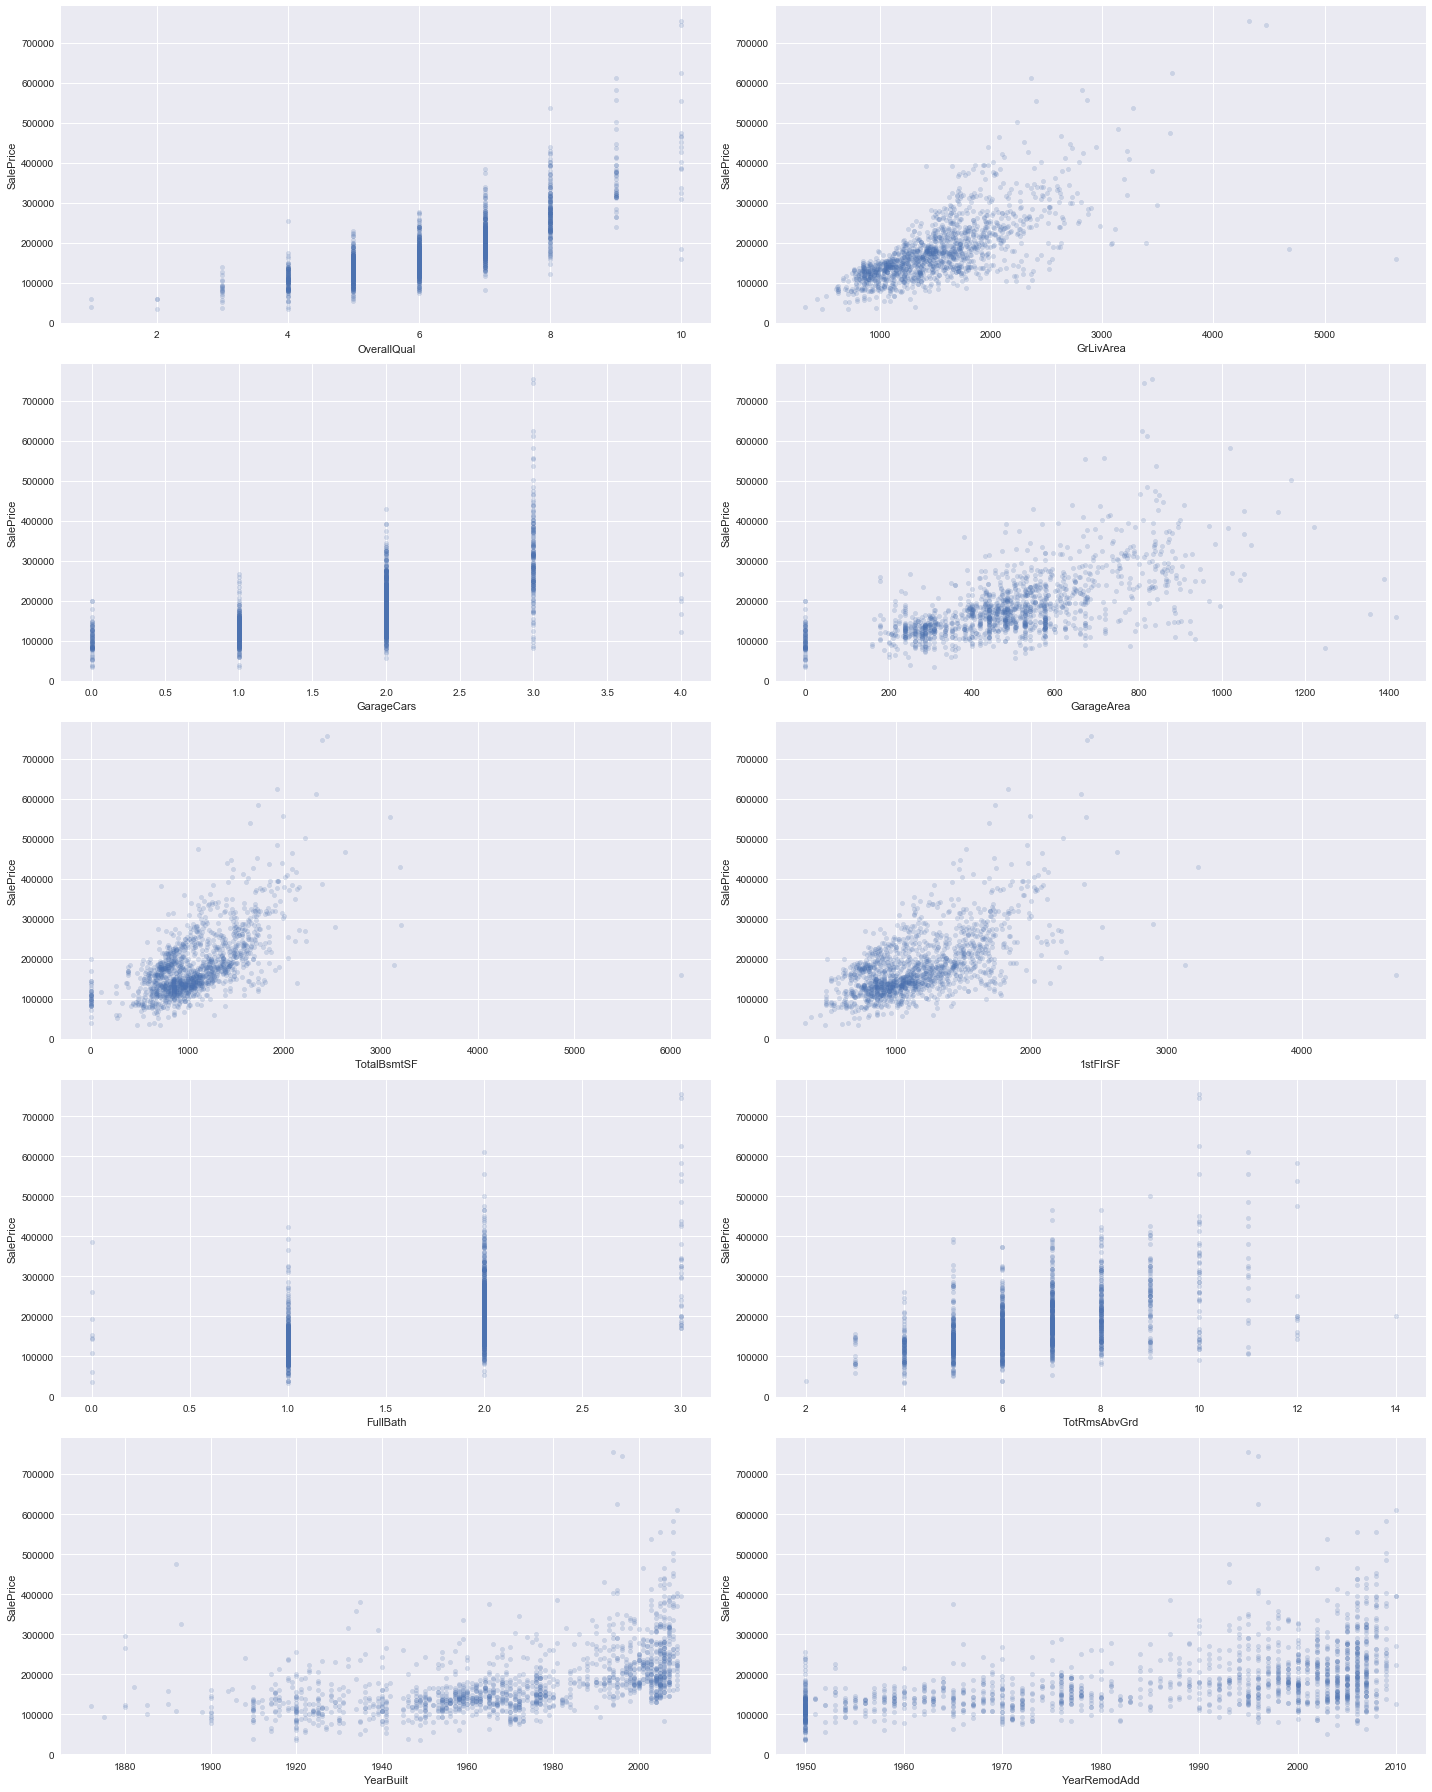

In [16]:
plot_scatters(train, top_pos_corr[1:11].index.values, "SalePrice", save_image=True, image_name='positive_correlations')

- Overall quality matters, although for each quality values, there are a wide range of prices, obviously due to the different types of properties one can find. It will be useful to see if a particular type does better than others.
- A bigger living area, space for more cars, a bigger basement and first floor are all important, however in all cases there are outliers which are slightly skewing the correlations. 
- There is a slight elevation of price for newer buildings.

Saving figure negative_correlations


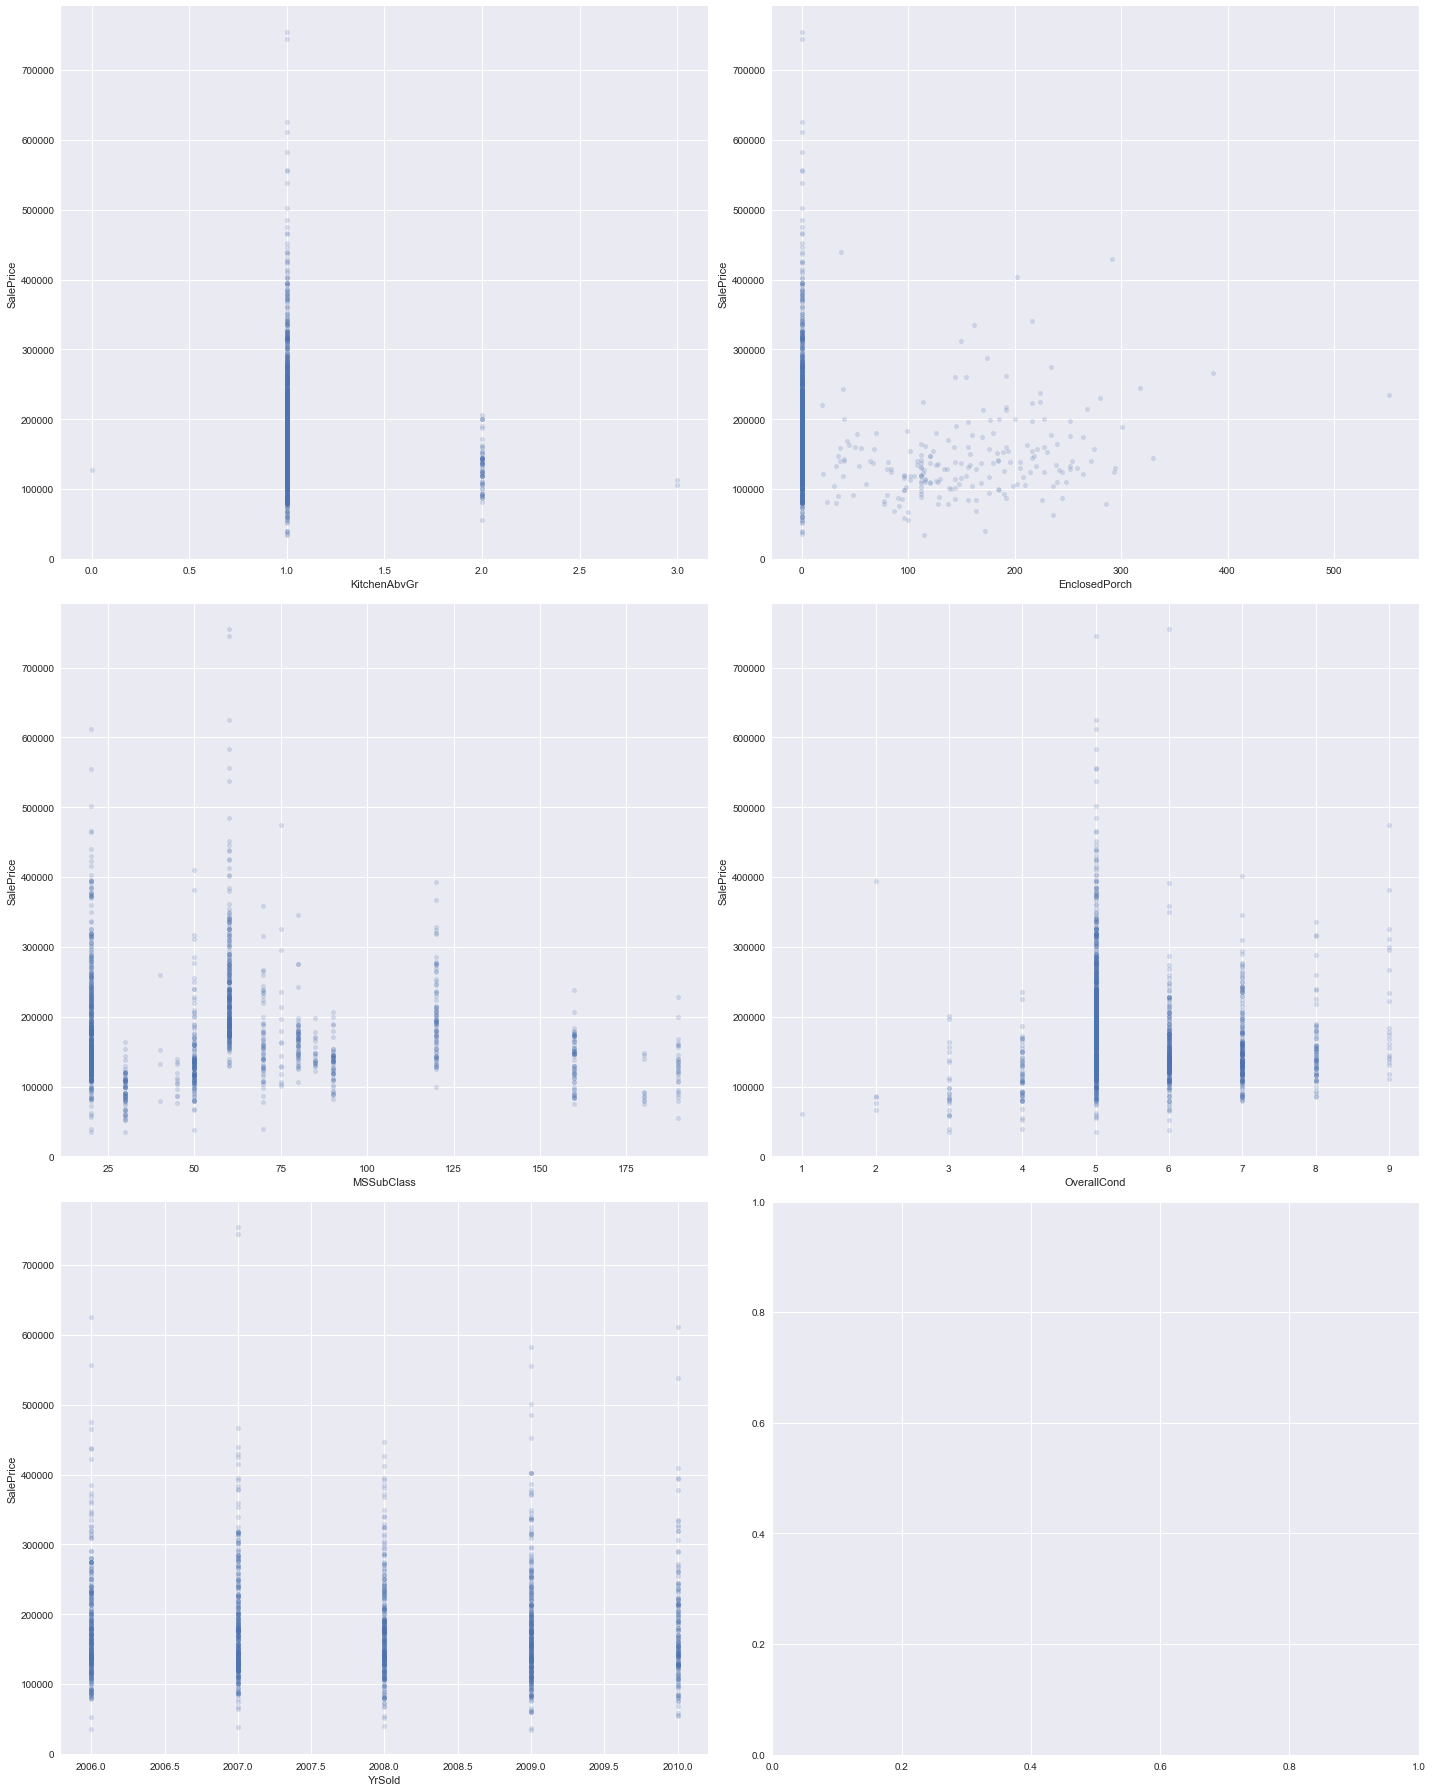

In [17]:
plot_scatters(train, top_neg_corr[:5].index.values, "SalePrice", save_image=True, image_name='negative_correlations')

- Fewer houses have more than one kitchen, but those that do seem to nagatively affect the sales price.
- The negative correlation for `EnclosedPorch` is due to the number of houses that have no porch. 
- Interesting that an `OverallCond` of 5 seems to contribute to the highest prices. We should explore this more. 

Let's study some of these a bit further. A handy function will be defined to explore individual variables and display
- A horizontal bar plot of value_counts for the levels of categorical variables as well as how each level contributes to the target variable.
- A histogram and box plot for numerical variables as well as correlation with the target variable.

In [18]:
# Used to explore a single feature on a set of subplots. 
# Visualise distribution, noise & outliers and missing values as well as correlation with target.
def explore_variable(df, feature, target, by_categorical=None):
    '''
    Numerical features will display 3 plots: histogram, correlation between source feature and a target and a box plot for feature. 
    Optional by_categorical can be provided to show box plot by levels of a categorical variable.
    Categorical features will display 2 plots: bar chart of levels, median of target by feature levels.
    '''    
    feature_type = df[feature].dtype
    missing = df.apply(lambda x: sum(x.isnull())).loc[feature]
    print("'{}' is of type {} with {} missing values".format(feature, feature_type, missing))

    if feature_type == "object":
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        fig.subplots_adjust(wspace=0.3)

        ax1 = ax.ravel()[0]
        ax1.set_title("Distribution of {}".format(feature))
        df[feature].value_counts().plot.barh(ax=ax1)

        ax2 = ax.ravel()[1]
        ax2.set_title("Median {} by {}".format(target, feature))
        df.groupby(feature)[[target]].median().plot.barh(ax=ax2)

        plt.show()

    elif feature_type == "int64" or "float64":
        fig, ax = plt.subplots(1, 3, figsize=(15,5))
        fig.subplots_adjust(wspace=0.3)

        ax1 = ax.ravel()[0]
        ax1.set_title("Distribution of {}".format(feature))
        df[feature].hist(bins=50, ax=ax1)

        ax2 = ax.ravel()[1]
        ax2.set_title("Correlation between {} and {}".format(feature, target))
        df.plot.scatter(x=feature, y=target, ax=ax2)  

        ax3 = ax.ravel()[2]
        ax3.set_title("Box plot for {}".format(feature))
        #df[feature].plot.box(ax=ax3)
        if by_categorical is not None:
            sns.boxplot(x=by_categorical, y=feature, data=df, ax=ax3)
        else:
            sns.boxplot(y=df[feature], ax=ax3)
        

        plt.show()


'SalePrice' is of type int64 with 0 missing values


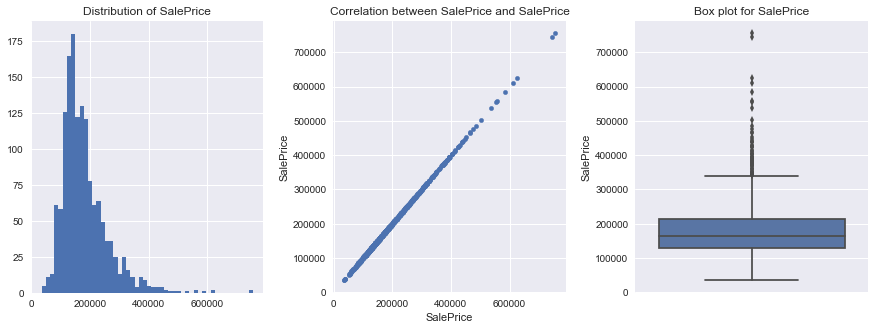

In [19]:
explore_variable(train, "SalePrice", "SalePrice")

The middle 50% of sales prices are between \$130K and \$210K with a median around \$150K. There are some outliers exceeding \$600K which we can investigate

In [20]:
train[train["SalePrice"] > 600000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,...,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000,train
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,...,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3,820,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657,train
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,...,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000,train
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,...,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000,train


These appear to be in `MSSubClass` 60 (2-STORY 1946 & NEWER) and 20 (1-STORY 1946 & NEWER ALL STYLES) in the Northridge and Northridge Heights neighbourhoods respectively. All the Northridge properties were built between 1994 - 1996 and are on large lot areas. We may want to remove these outliers in order for our models to perform better.

'OverallQual' is of type int64 with 0 missing values


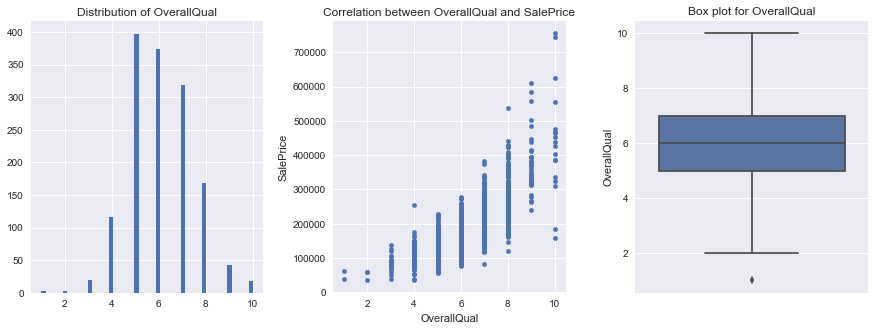

In [21]:
explore_variable(train, "OverallQual", "SalePrice")

Most properties tend to score between 5 and 7 for overall quality and in general, as quality improves, price increases, as one might expect. 

'GrLivArea' is of type int64 with 0 missing values


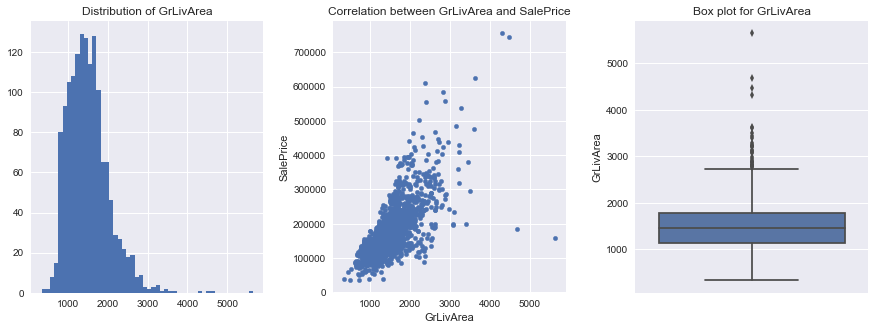

In [22]:
explore_variable(train, "GrLivArea", "SalePrice")

In [23]:
train[(train["GrLivArea"] > 4000) & (train["SalePrice"] > 700000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,...,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000,train
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,...,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000,train


In [24]:
train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 200000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,...,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750,train
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,...,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000,train


All the outliers with a ground living space area greater than 4000 square feet seems to of type `2-STORY 1946 & NEWER`, those with the really high selling price are in `Northridge` while the lowest are in `Edwards`. All are `2Story` houses. The Northridge properties were built in the 90's while the Edwards properties were built in 2007/8. 

'YearRemodAdd' is of type int64 with 0 missing values


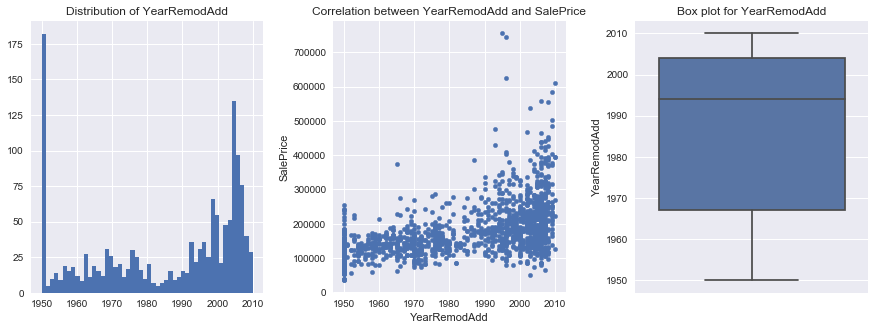

In [25]:
explore_variable(train, "YearRemodAdd", "SalePrice")

'YearBuilt' is of type int64 with 0 missing values


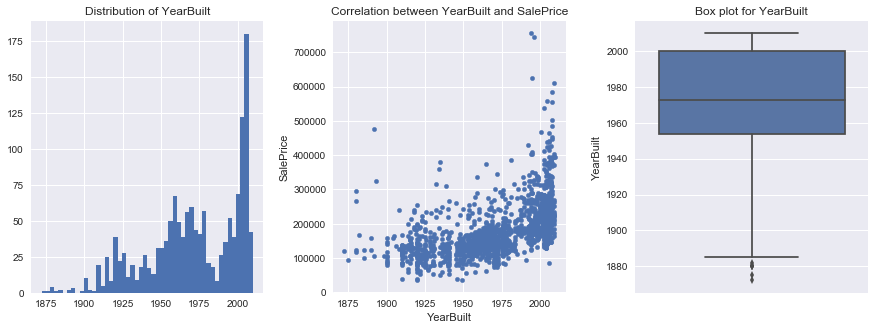

In [26]:
explore_variable(train, "YearBuilt", "SalePrice")

Let's take a look at how sales price varies amonst different neighbourhoods and house styles

'Neighborhood' is of type object with 0 missing values


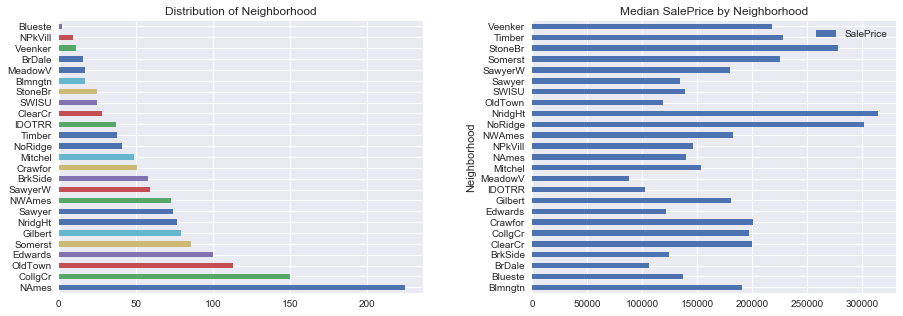

In [27]:
explore_variable(train, "Neighborhood", "SalePrice")

North Ames, College Creek and Old Town have the most properties while Northridge Heights, Northridge and Stone Brook have the highest value properties. 

'HouseStyle' is of type object with 0 missing values


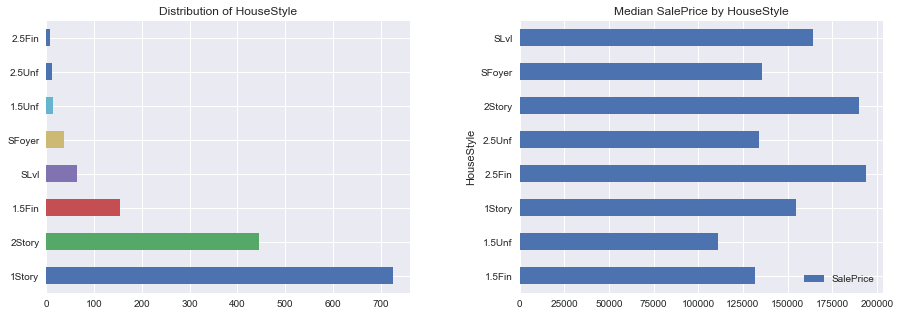

In [28]:
explore_variable(train, "HouseStyle", "SalePrice")

Single and double story houses are the most common and 2.5 and double story proerpties attract the highest selling prices.

Let's further see how overall quality varies by house type and neighbourhood and how that affects the sales price.

Saving figure sale_price_by_quality_house_style


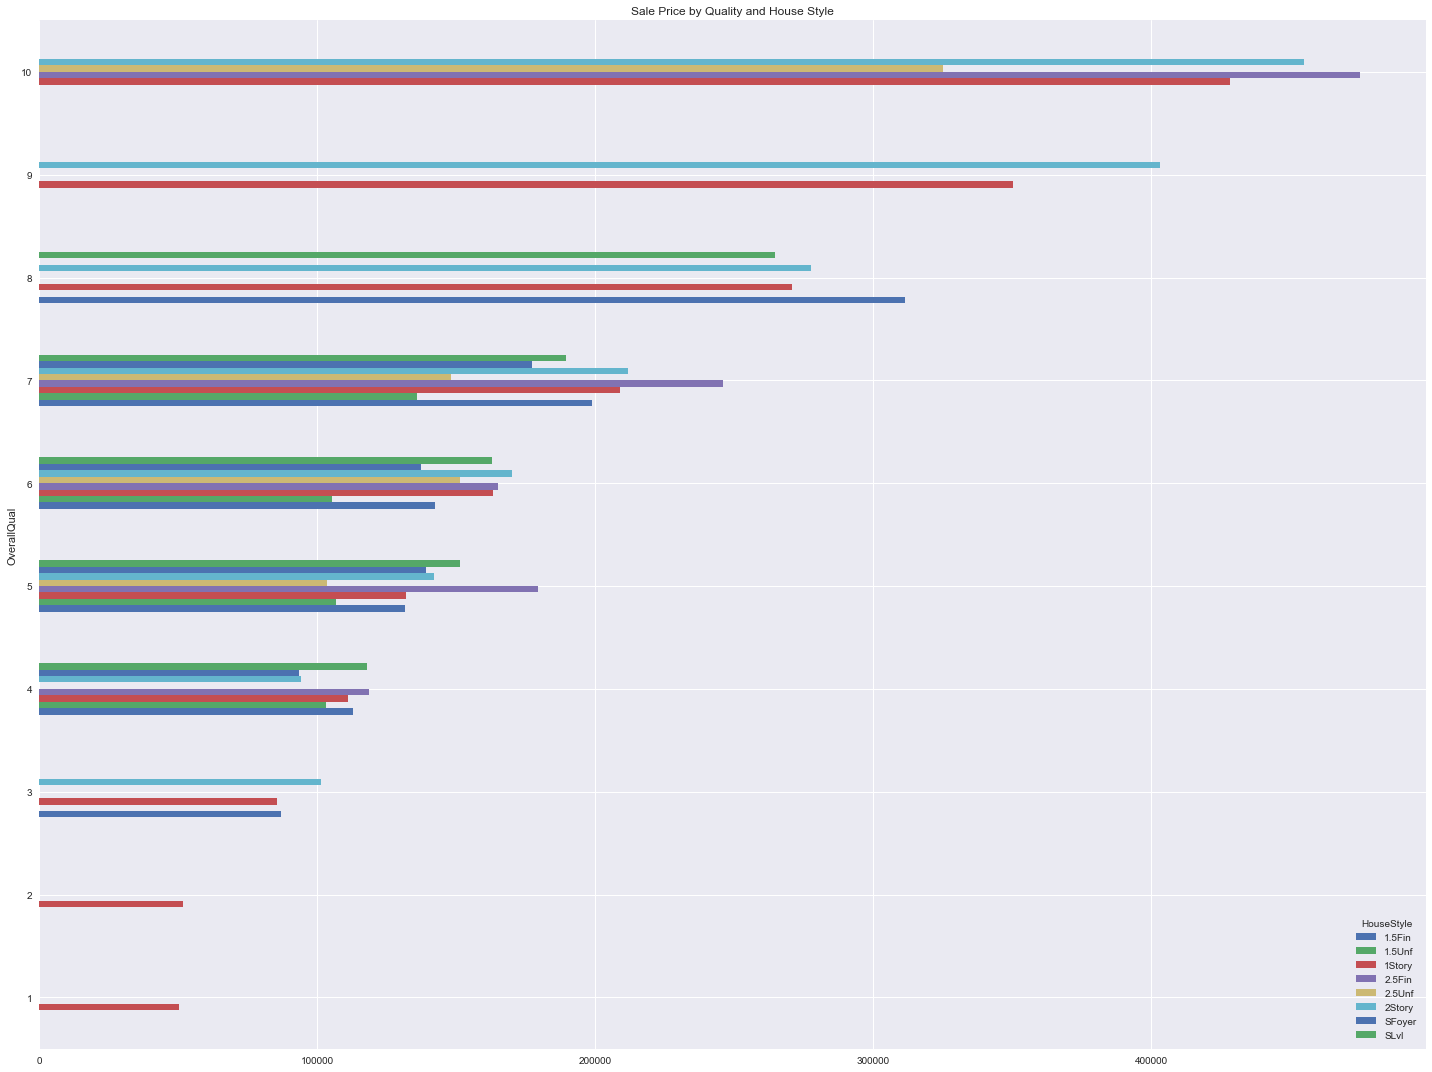

In [29]:
pd.pivot_table(data=train, index='OverallQual', values='SalePrice', columns='HouseStyle').plot.barh(figsize=(20,15), title='Sale Price by Quality and House Style')
save_fig("sale_price_by_quality_house_style")

2.5 story, double story and single story properties tend to get the maximum quality ratings the most. 

Saving figure gr_floor_area_by_quality_house_style


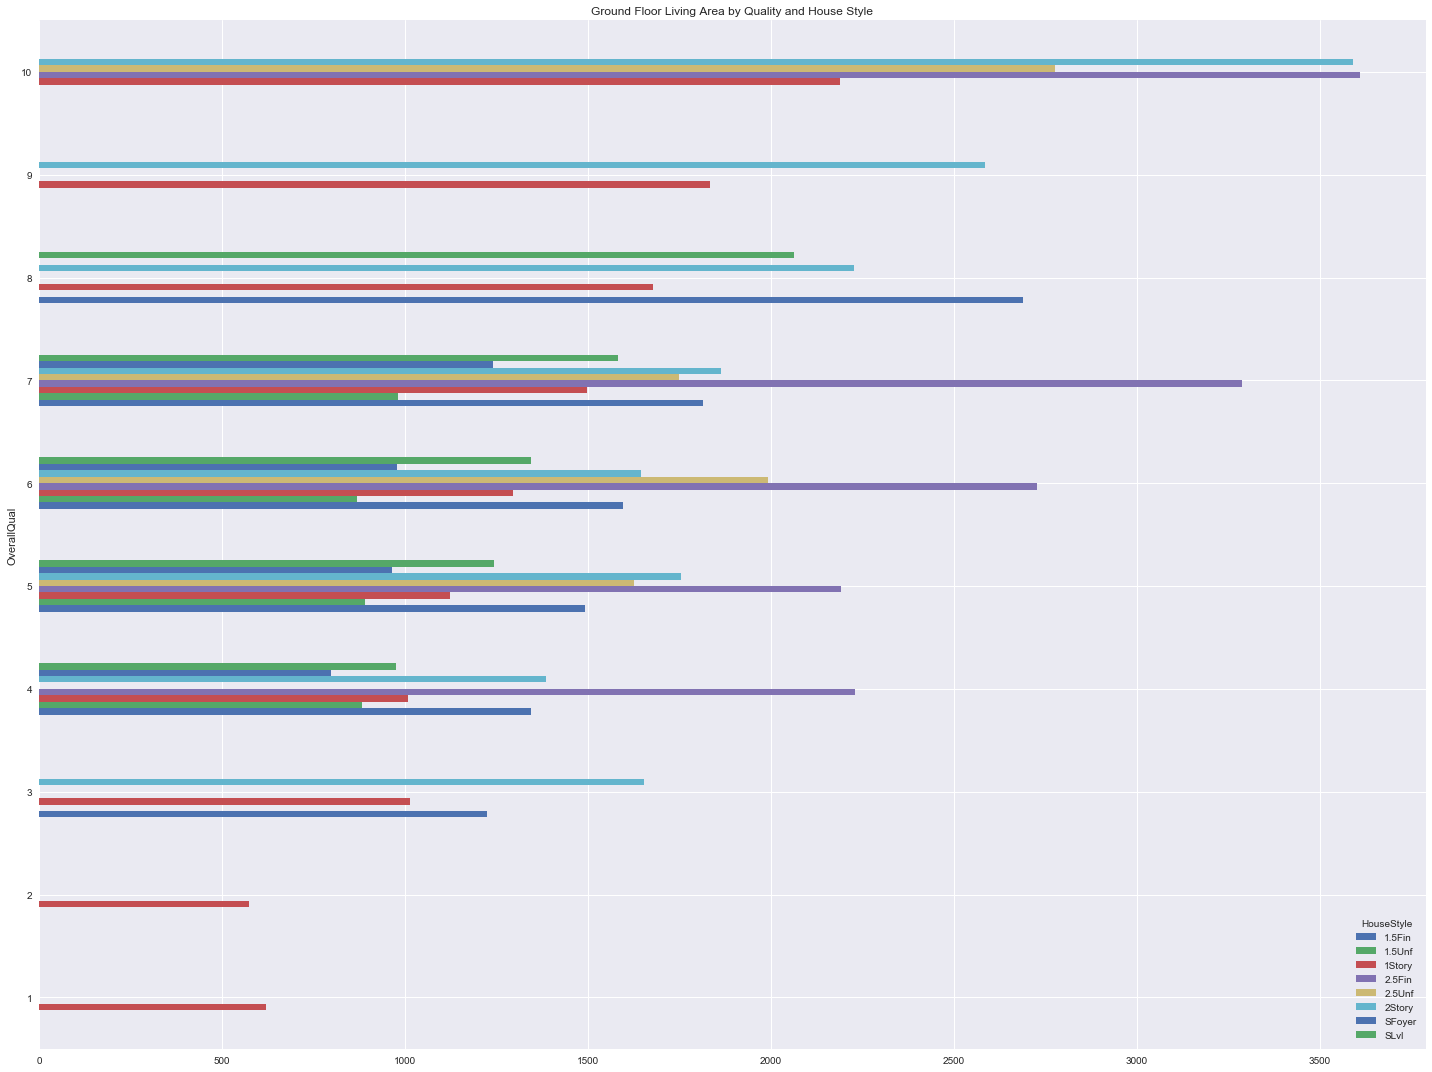

In [30]:
pd.pivot_table(data=train, index='OverallQual', values='GrLivArea', columns='HouseStyle').plot.barh(figsize=(20,15), title='Ground Floor Living Area by Quality and House Style')
save_fig("gr_floor_area_by_quality_house_style")

Double story and 2.5 finished properties tend to have the biggest living areas while attracting the highest ratings. 

Saving figure mean_quality_by_neighbourhood


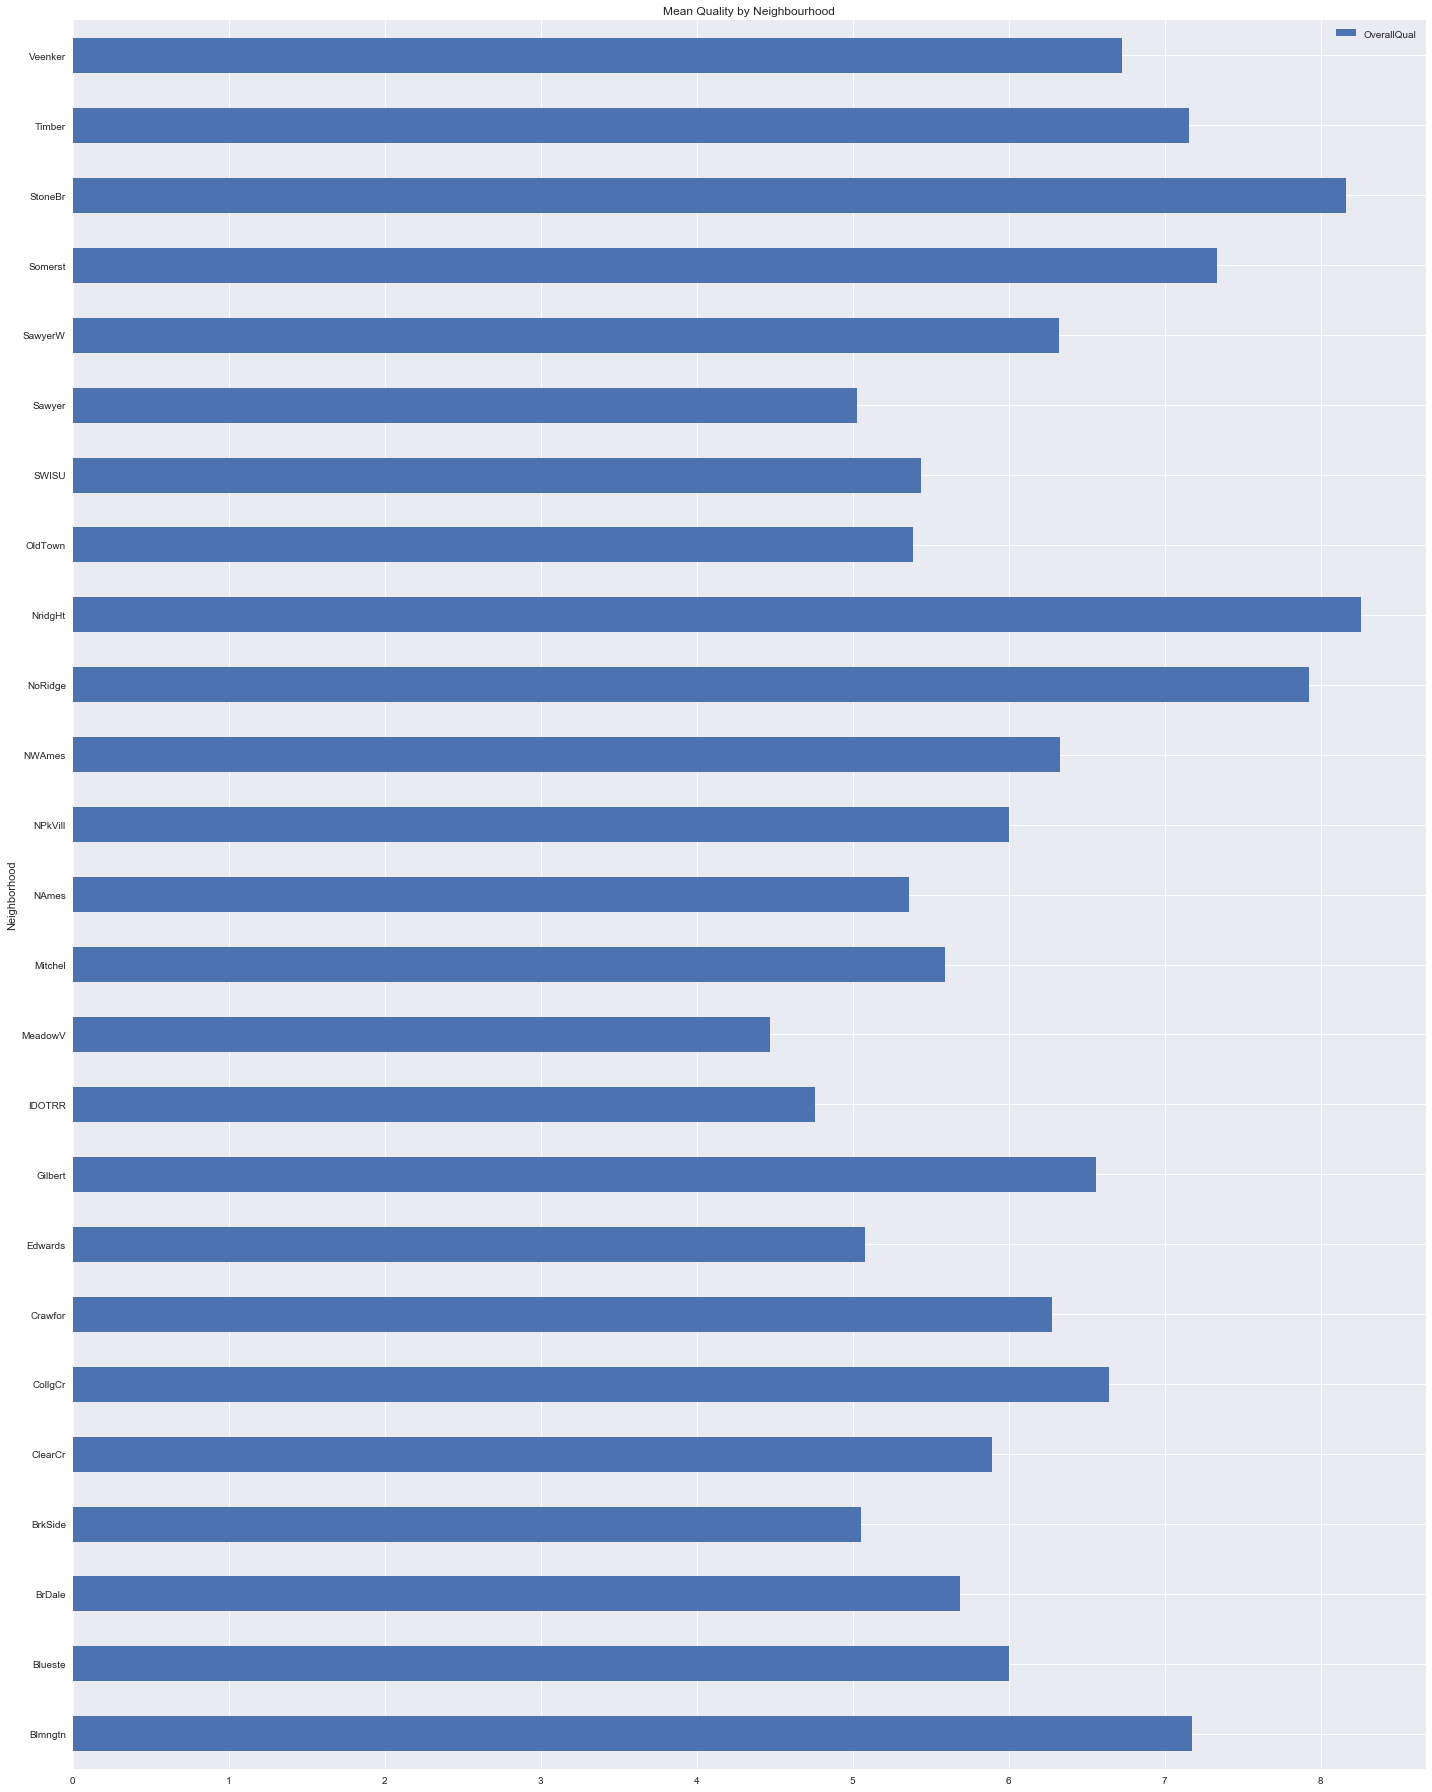

In [31]:
pd.pivot_table(data=train, index='Neighborhood', values='OverallQual').plot.barh(figsize=(20,25), title='Mean Quality by Neighbourhood')
save_fig("mean_quality_by_neighbourhood")

Properties in Stone Brook, Northridge, ,Northridge Heights, Bloomington Heights and Gilbert tend to get the highest ratings.

In [32]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,...,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,...,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,...,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,...,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,...,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,train


Saving figure sale_price_by_full_bathrooms


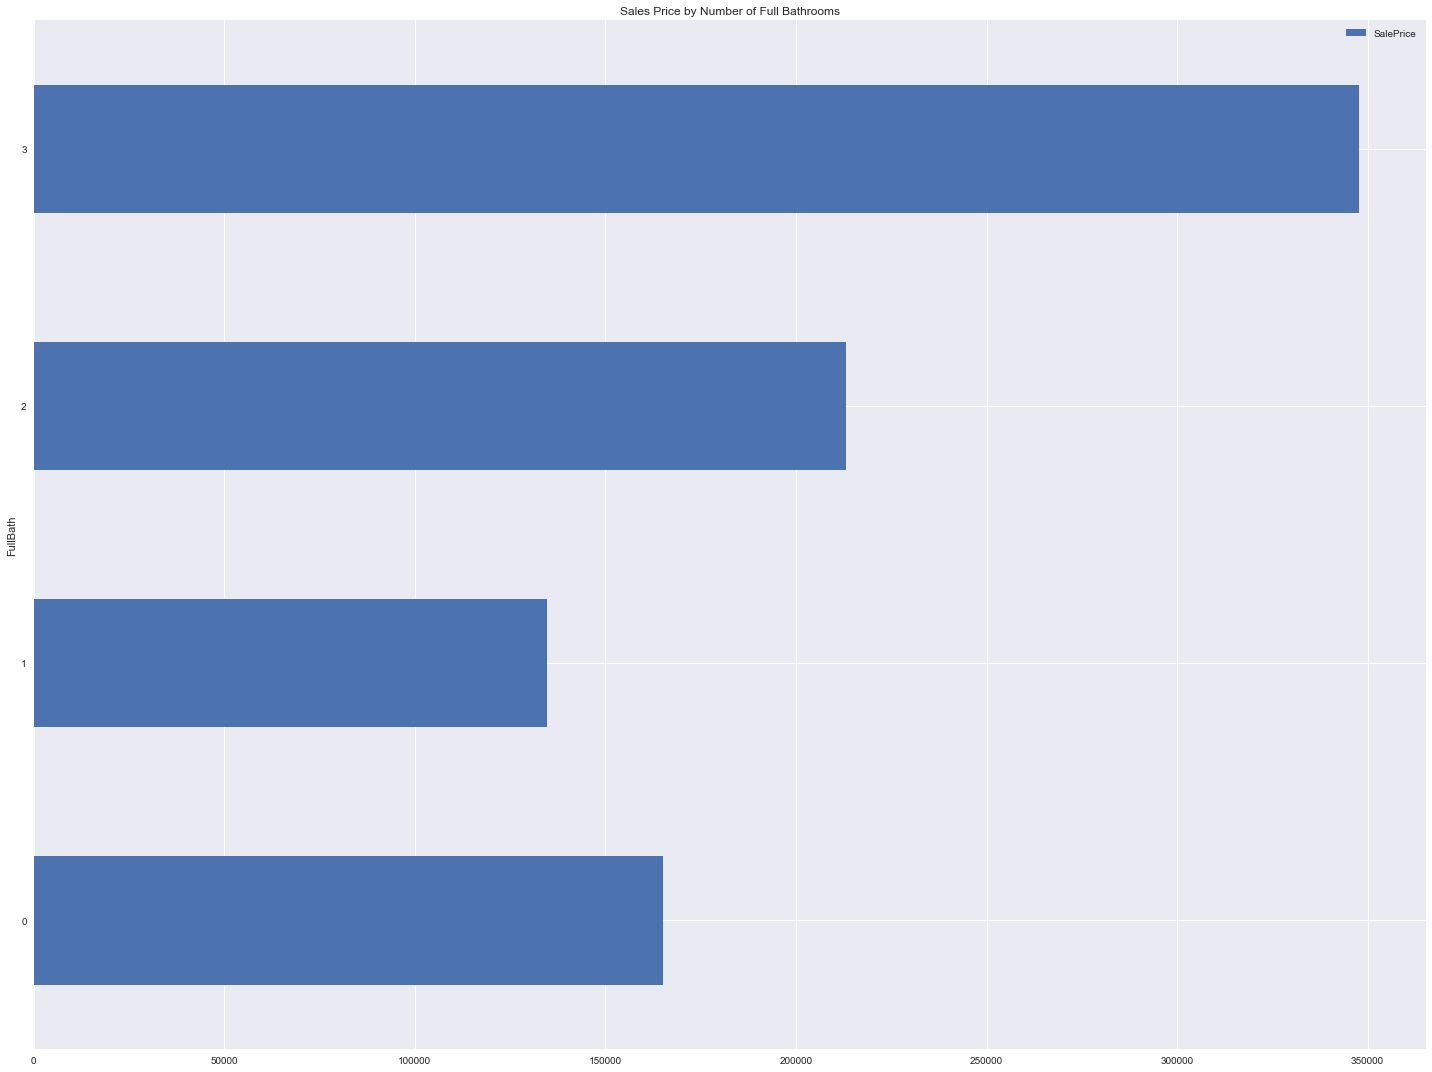

In [33]:
pd.pivot_table(data=train, index='FullBath', values='SalePrice').plot.barh(figsize=(20,15), title='Sales Price by Number of Full Bathrooms')
save_fig("sale_price_by_full_bathrooms")

Strange that properties with 0 full bathrooms sell for higher than those with 1. Let's take a look at those.

In [34]:
train[train["FullBath"] == 0]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source
53,54,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,Gd,TA,CBlock,...,1,Gd,5,Typ,1,Gd,Attchd,1981.0,Fin,3,894,TA,TA,Y,857,72,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000,train
188,189,90,RL,64.0,7018,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,Duplex,SFoyer,5,5,1979,1979,Gable,CompShg,Plywood,Plywood,Stone,275.0,TA,TA,CBlock,...,2,TA,6,Typ,2,TA,Detchd,1979.0,Unf,2,528,TA,TA,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Alloca,153337,train
375,376,30,RL,NaN,10020,Pave,NaN,IR1,Low,AllPub,Inside,Sev,Edwards,Norm,Norm,1Fam,1Story,1,1,1922,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,BrkTil,...,1,Fa,4,Maj1,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Normal,61000,train
597,598,120,RL,53.0,3922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,BrkFace,72.0,Gd,TA,PConc,...,1,Gd,7,Typ,1,Gd,Attchd,2006.0,Fin,3,648,TA,TA,Y,120,16,0,0,0,0,NaN,NaN,NaN,0,2,2007,New,Partial,194201,train
634,635,90,RL,64.0,6979,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,Duplex,SFoyer,6,5,1980,1980,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,...,2,TA,4,Typ,0,NaN,Detchd,1980.0,Unf,2,576,TA,TA,Y,264,56,0,0,0,0,NaN,GdPrv,Shed,600,6,2010,WD,Normal,144000,train
916,917,20,C (all),50.0,9000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,3,1949,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,...,1,TA,4,Typ,0,NaN,Detchd,1958.0,Unf,1,308,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2006,WD,Abnorml,35311,train
1163,1164,90,RL,60.0,12900,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,Norm,Duplex,SFoyer,4,4,1969,1969,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,...,2,TA,6,Typ,0,NaN,CarPort,1969.0,Unf,2,400,Fa,TA,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Alloca,108959,train
1213,1214,80,RL,NaN,10246,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,SLvl,4,9,1965,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,...,1,TA,3,Typ,0,NaN,Attchd,1965.0,Unf,1,364,TA,TA,Y,88,0,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,145000,train
1270,1271,40,RL,NaN,23595,Pave,NaN,Reg,Low,AllPub,Inside,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,6,1979,1979,Shed,WdShake,Plywood,Plywood,None,0.0,Gd,TA,PConc,...,1,Gd,4,Typ,1,TA,Attchd,1979.0,Fin,2,586,TA,TA,Y,268,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,260000,train


In [35]:
train[train["FullBath"] == 0]["YearBuilt"].describe()

count       9.000000
mean     1970.000000
std        23.584953
min      1922.000000
25%      1965.000000
50%      1979.000000
75%      1980.000000
max      2006.000000
Name: YearBuilt, dtype: float64

They seem to be older properties, maybe with some old-school charm :)

## Observations

Based on all the above, we'll do the following as part of a first round of data prep and feature engineering:
- Outliers will be removed from `SalePrice`, `GrLivArea`, `GarageArea`, `TotalBsmtSF`, `1stFlrSF` and `EnclosedPorch`. Initially we'll remove anything that is less than `first quartile x 1.5IQR` and above `third quartile x 1.5IQR`. 
- Missing categorical levels corresponding to the lack of that category will be added with values such as `No Basement` etc.
- Convert `MSSubClass` to categorical
- Remove outliers on YearBuilt and add feature `YearSinceBuild` counting number of years since house was built
- Add features `HasRemod` == 1 if house has been remodelled and `YearSinceRemod` counting how many years since remodelling if `HasRemod` == 1. 
- Add `YearSoldSinceRemod` which gives the years between selling and remodelling.
- Remove all the year columns. 
- Missing values for other categorical variables will be filled in with the most common value
- Missing numerical values with be imputed with either the mean or median, both will be tested.

After we've got a baseline from all of these transformations and additions, we'll look at engineering some additional features.

# Prepare the Data

We'd like to automate as much of our pipeline processing as possible, making us of scikit-learn's transformer and pipeline facilties. We'll write our own customer transformers where needed and build functions that allow us to train and measure different models easily and quickly.

## Creating Transformer Functions

In order to remove outliers easily we'll create the following transformer. One can provide the transformer with a selection of features, the IQR range multiple to use for outlier removal and whether lows, highs or both should be removed.

- `OutlierRemover` will be used to remove outliers that fall in a specified range.

In [36]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, outlier_params):
        self.features = outlier_params["features"]
        self.irq_ranges = outlier_params["range"]
        self.remove_lows = outlier_params["remove_lows"]
        self.remove_highs = outlier_params["remove_highs"]
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):     
                
        first_quartile = X.describe().loc["25%"]
        third_quartile = X.describe().loc["75%"]
        iqr = third_quartile - first_quartile
                      
        # find rows subset that should be removed for each feature and irq range
        # Perform boolean AND to decide if row is to be removed - at least one True is needed.
        
        row_filters = []
        for feature, iqr_multiplier, remove_low, remove_high in zip(self.features, self.irq_ranges, self.remove_lows, self.remove_highs):
            
            if remove_low and remove_high: 
                low_high_filter = (X[feature] > (first_quartile[feature] - iqr_multiplier * iqr[feature])) &(X[feature] < (third_quartile[feature] + iqr_multiplier * iqr[feature]))
                row_filters.append(low_high_filter)
               
            
            elif remove_low and not remove_high:
                row_filters.append(X[feature] > (first_quartile[feature] - iqr_multiplier * iqr[feature]))
                
            elif not remove_low and remove_high:
                row_filters.append(X[feature] < (third_quartile[feature] + iqr_multiplier * iqr[feature]))
                
            else:
                pass
        
        row_filter = row_filters[0]        
        for option in row_filters[1:]:
            row_filter = row_filter & option
        
        return X[row_filter]


Let's test it out

In [37]:
sample = train.copy()

In [38]:
outlier_params = {
    "features": ["SalePrice", "YearBuilt", "YearRemodAdd"], 
    "range": [1.5, 1.5, 1.5], 
    "remove_lows": [True, True, True],
    "remove_highs": [True, False, True]
}

outlier_pipeline = Pipeline([("outlier_removal", OutlierRemover(outlier_params))])
df_outliers_removed = outlier_pipeline.fit_transform(sample)
print(sample.shape, df_outliers_removed.shape)

(1460, 82) (1390, 82)


We can see that 70 rows have been removed. The outlier processor will remove rows that end up matching any of the conditions.

In [39]:
sample[sample['SalePrice'] > 600000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,...,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000,train
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,...,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3,820,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657,train
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,...,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000,train
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,...,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000,train


In [40]:
df_outliers_removed[df_outliers_removed['SalePrice'] > 600000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source


In order to fill in the missing category levels as well as impute the most frequent level (for the categorical variable that don't form part of this set), we'll create two more custom transformers.

- `MostFrequentImputer` will be used to find the most common value in a categorical column and use that for missing values.
- `ApplyNACategory` will apply the correct label (such as `No Basement`) to columns that were incorrectly marked as `np.nan` 

In [41]:
class AddLevelImputer(BaseEstimator, TransformerMixin):
    def __init__(self, na_dict, df_out=False):
        self.na_dict = na_dict
        self.df_out = df_out
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.df_out:
            return X.fillna(value=self.na_dict)
        else:
            return np.c_[X.fillna(value=self.na_dict)]
    
from sklearn.base import BaseEstimator, TransformerMixin
# Inspired from stackoverflow.com/questions/25239958

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def __init__(self, df_out=False):
        self.df_out = df_out
        
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)

        return self
    def transform(self, X, y=None):
        if self.df_out:
            return X.fillna(self.most_frequent_)
        else:
            return np.c_[X.fillna(self.most_frequent_)]
        

Let's test both out

In [42]:
# these are obtained from the data dictionary
na_dict = {
    "Alley": "No Alley Access",
    "MasVnrType": "None",
    "BsmtQual": "No Basement",
    "BsmtCond": "No Basement",
    "BsmtExposure": "No Basement",
    "BsmtFinType1": "No Basement",
    "BsmtFinType2": "No Basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None"
}


cat_pipeline = Pipeline([
    ("apply_na", AddLevelImputer(na_dict, True)),
    ("cat_imputer", MostFrequentImputer(True))
])

df_cat_levels_added = cat_pipeline.fit_transform(sample)
missing_values_table(df_cat_levels_added)

Your selected dataframe has 82 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [43]:
df_cat_levels_added["BsmtQual"].value_counts()

TA             649
Gd             618
Ex             121
No Basement     37
Fa              35
Name: BsmtQual, dtype: int64

In [44]:
df_cat_levels_added["FireplaceQu"].value_counts()

No Fireplace    690
Gd              380
TA              313
Fa               33
Ex               24
Po               20
Name: FireplaceQu, dtype: int64

We can see that the values have been replaced as desired.

In order to transform features (log, sqrt etc.) or to apply change of columns types, such as with `MSSubClass`, we'll define a customer transformer.
- `FeatureTransformer` can apply a user defined function or lambda to a specific set of columns. Transformations will be applied directly.
- `FeatureTransformerAdder` same as FeatureTransformer but can also create new columns and remove the old ones. Care must be taken when used as part of a pipeline as it can lead to mismatched columns at different steps in the pipeline.

In [45]:
class FeatureTransformerAdder(BaseEstimator, TransformerMixin):
    def __init__(self, feature_transform_params, df_out=False):
        self.features = feature_transform_params["features"]
        self.transformations = feature_transform_params["operations"]
        self.col_prefixes = feature_transform_params["prefixes"]
        self.remove_original = feature_transform_params["remove_original"]
        self.df_out = df_out
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for feature, transform, prefix, remove in zip(self.features, self.transformations, self.col_prefixes, self.remove_original):
            col_name = prefix + "_" + feature
            X[col_name] = X[feature].apply(transform)
            if remove:
                X.drop(feature, axis=1, inplace=True)
        if self.df_out:
            return X
        else:
            return np.c_[X]

In [46]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_transform_params, df_out=True):
        self.features = feature_transform_params["features"]
        self.transforms = feature_transform_params["transforms"]
        self.is_type_change = feature_transform_params["is_type_change"]
        self.df_out = df_out            
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if isinstance(X,(pd.core.series.Series, pd.core.frame.DataFrame)):
            for feature, transform, is_change in zip(self.features, self.transforms, self.is_type_change):
                if is_change:                    
                    X[feature] = X[feature].astype(transform)
                else:
                    X[feature] = X[feature].apply(transform)
        if self.df_out:
            return X
        else:
            return np.c_[X]

Let's apply a log transformation to `LotArea` 

In [47]:
feature_transform_params = {
    "features": ["LotArea"],
    "operations": [np.log],
    "prefixes": ["log"],
    "remove_original": [False]
}

transform_pipeline = Pipeline([("transform_features", FeatureTransformerAdder(feature_transform_params, True))])
df_transformed = transform_pipeline.fit_transform(sample)
df_transformed.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source,log_LotArea
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,...,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,train,9.041922
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,...,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,train,9.169518
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,...,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,train,9.328123
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,...,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,train,9.164296
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,...,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,train,9.565214


Lets return a `numpy` array instead (important when we are running pipelines)

In [48]:
transform_pipeline = Pipeline([("transform_features", FeatureTransformerAdder(feature_transform_params, False))])
df_transformed = transform_pipeline.fit_transform(sample)
df_transformed

array([[1, 60, 'RL', ..., 208500, 'train', 9.041921720351219],
       [2, 20, 'RL', ..., 181500, 'train', 9.169518377455928],
       [3, 60, 'RL', ..., 223500, 'train', 9.328123407632566],
       ...,
       [1458, 70, 'RL', ..., 266500, 'train', 9.109635667854551],
       [1459, 20, 'RL', ..., 142125, 'train', 9.181632207839439],
       [1460, 20, 'RL', ..., 147500, 'train', 9.204020443231363]],
      dtype=object)

Now let's transform and remove `LotArea` and `MSSubClass`

In [49]:
feature_transform_params = {
    "features": ["LotArea", "MSSubClass"],
    "operations": [np.log, lambda x: str(x)],
    "prefixes": ["log", "str"],
    "remove_original": [True, True]
}

transform_pipeline = Pipeline([("transform_features", FeatureTransformerAdder(feature_transform_params, True))])
df_transformed = transform_pipeline.fit_transform(sample)
df_transformed.head()

,Id,MSZoning,LotFrontage,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,...,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source,log_LotArea,str_MSSubClass
0,1,RL,65.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,...,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,train,9.041922,60
1,2,RL,80.0,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,...,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,train,9.169518,20
2,3,RL,68.0,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,...,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,train,9.328123,60
3,4,RL,60.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,...,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,train,9.164296,70
4,5,RL,84.0,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,...,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,train,9.565214,60


Next will add an imputer which allows us to get replace infinities with `np.nan`
- `InfImputer` replaces all `np.inf` or `-np.inf` values with `np.nan`. It is important that there are no infinity values before we attempt standard scaling of the data.

In [50]:
class InfImputer(BaseEstimator, TransformerMixin):
    def __init__(self, df_out=False):
        self.df_out = df_out
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X[(X == np.inf) | (X == -np.inf)] = np.nan
        if self.df_out:
            return X
            
        else:
            return np.c_[X]

In [51]:
df_infinity = pd.DataFrame({"A": [np.inf, 50, 40, -np.inf]})
df_infinity

,A
0,inf
1,50.000000
2,40.000000
3,-inf


In [52]:
InfImputer(True).fit_transform(df_infinity)

,A
0,NaN
1,50.0
2,40.0
3,NaN


`CrossFeatureTransformerAdder` can apply operations between multiple columns and create new features from the result. Care must be taken when used as part of a pipeline as it can lead to mismatched columns.

In [53]:
class CrossFeatureTransformerAdder(BaseEstimator, TransformerMixin):
    def __init__(self, feature_adder_params, df_out=False): # no *args or **kargs
        self.base_features_ids = feature_adder_params["base_features_ids"]
        self.operations = feature_adder_params["operations"]
        self.df_out = df_out
        if self.df_out:
            self.feature_names = feature_adder_params["feature_names"]
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):      
        if self.df_out:
            new_features = []        
            for base_ids, operation, name in zip(self.base_features_ids, self.operations, self.feature_names): 
                X[name] = operation(X.ix[:, base_ids[0]], X.ix[:, base_ids[1]])
        else:
            new_features = []    
            if isinstance(X,(pd.core.series.Series, pd.core.frame.DataFrame)):
                X = X.values
            for base_ids, operation in zip(self.base_features_ids, self.operations):  
                new_features.append(operation(X[:, base_ids[0]], X[:, base_ids[1]]))        

            for feature in new_features:
                X = np.c_[X, feature]
        
        return X

In [54]:
df = pd.DataFrame({"A": [10, 20, 30], "B": [20, 30, 40]})
df

,A,B
0,10,20
1,20,30
2,30,40


In [55]:
feature_adder_params = {
    "base_features_ids": [(0, 1), (1, 0)],
    "operations": [np.subtract, np.divide],
    "feature_names": ["A - B", "B/A"]
}

CrossFeatureTransformerAdder(feature_adder_params, True).fit_transform(df.copy())

,A,B,A - B,B/A
0,10,20,-10,2.000000
1,20,30,-10,1.500000
2,30,40,-10,1.333333


In [56]:
CrossFeatureTransformerAdder(feature_adder_params, False).fit_transform(df.copy())

array([[ 10.        ,  20.        , -10.        ,   2.        ],
       [ 20.        ,  30.        , -10.        ,   1.5       ],
       [ 30.        ,  40.        , -10.        ,   1.33333333]])

## Creating Selector Functions

Now that we've defined some transformers, let's define some useful selectors. Unlike the transformers defined above, these assume a Pandas dataframe or series input and will be used as the first step in the pipeline. 
- `DataFrameSelector` will allow us to select columns from a pandas dataframe and covert it for use with scikit-learn.
- `TypeSelector` allows us to select columns of a specific type from a dataframe. We can choose all columns or a selection by passing in the appropriate values.
- `TopFeatureSelector` will allow us to choose a selection of the top performing features before further applying the pipeline.

In [57]:
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
class TypeSelector(BaseEstimator, TransformerMixin):
    '''
    Select features of a specific type. if choose='all' then all features of that type will be selected and features will have no affect.
    If choose='select' then features mujst contain a list of features matching dtype
    '''
    def __init__(self, dtype, choose="all", features=None):
        self.dtype = dtype
        self.choose = choose
        self.features = features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.choose == "all":
            return X.select_dtypes(include=[self.dtype])
        elif self.choose == "select":
            if self.features is not None:
                return X.select_dtypes(include=[self.dtype])[self.features]
                
            else:
                raise ValueError('features must contain a list of features of type', self.dtype, 'if choose="select"')

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Let's try it all out

In [58]:
num_pipeline = Pipeline([("numerics", TypeSelector(np.number, "all"))])
bool_pipeline = Pipeline([("booleans", TypeSelector('bool', "all"))])
cat_pipeline = Pipeline([("categoricals", TypeSelector('object', "all"))])

num_pipeline.fit_transform(train).head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [59]:
cat_pipeline.fit_transform(train).head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,source
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,train
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,train
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,train
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml,train
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,train


If we want to select a specific subset of features

In [60]:
num_pipeline = Pipeline([("numerics", TypeSelector(np.number, "select", ["LotFrontage", "OverallQual"]))])
cat_pipeline = Pipeline([("categoricals", TypeSelector('object', "select", ["MSZoning", "Neighborhood"]))])

In [61]:
num_pipeline.fit_transform(train).head()

,LotFrontage,OverallQual
0,65.0,7
1,80.0,6
2,68.0,7
3,60.0,7
4,84.0,8


In [62]:
cat_pipeline.fit_transform(train).head()

,MSZoning,Neighborhood
0,RL,CollgCr
1,RL,Veenker
2,RL,CollgCr
3,RL,Crawfor
4,RL,NoRidge


We can use DataFrameSelector if we don't care about data type and just want to select features.

In [63]:
features_pipeline = Pipeline([("features", DataFrameSelector(["LotFrontage", "OverallQual"]))])
features_pipeline.fit_transform(train).head()

,LotFrontage,OverallQual
0,65.0,7
1,80.0,6
2,68.0,7
3,60.0,7
4,84.0,8


## Creating Model Fitting and Evaluation Functions

- `determine_one_hot_cat_features` will be used during model fitting and evaluation. It will allow us to determine all the generated categorical features that have been created in the pipeline procecss. We can pass these to our model measurements function `measure_regression_model` which uses this for plotting purposes. 
- `build_run_model` allows to build a pipeline for processing numerical, boolean and categorical features and it executes CV based on specified parameters. It allows one to easily test different model ideas, feature selections and parameter tuning, all while making use of scikit-learn's robust pipeline infrastructure. 
- `measure_regression_model` can be run on a model once CV has been completed. It does three things:  
    - Shows high-level statstics for CV included the mean, standard deviation, min and max CV scores.
    - Plots the features importances as derived from CV.
    - Plots a learning curve
    - Returns a sorted dataset with the original values, target feature and predictions, sorted by worst performing rows, descending. This can be used for furuther analysis. 

In [64]:
def determine_one_hot_cat_features(cat_pipeline, original_cat_features, bool_pipeline, original_bool_features):
    #print(cat_pipeline)
    #print(original_cat_features)
    mappings = {}
    for feature, levels in zip(original_cat_features, cat_pipeline.named_steps["cat_encoder"].categories_):
        mappings[feature] = levels
    for feature, levels in zip(original_bool_features, bool_pipeline.named_steps["bool_encoder"].categories_):
        mappings[feature] = levels
    features_list = []
    for feature, levels in mappings.items():
        new_levels = [feature + "_" + str(level) for level in levels]
        features_list.append(new_levels)
        
    
    return [feature for group in features_list for feature in group]

In [65]:
def build_run_model(alg, train, target, num_pipelines, cat_pipelines, bool_pipelines, pre_remove_identifiers=None, 
                    feature_add_remove_pipeline=None, feature_transform_pipeline=None, outlier_pipeline=None, feature_list=None, 
                    num_important_features=5, cv=10, scoring="neg_mean_squared_error", save_model=False, save_model_name="model"):
   
    train = train.copy()
    
    if outlier_pipeline is not None:
        train = outlier_pipeline.fit_transform(train)    
        
    if pre_remove_identifiers is not None:
        print("\nRemoving features:", pre_remove_identifiers)
        train = train.drop(pre_remove_identifiers, axis=1)
    
    labels = train[target].copy()   
    train.drop([target], axis=1, inplace=True)
    
    if feature_add_remove_pipeline is not None:
        train = feature_add_remove_pipeline.fit_transform(train)
    
    if feature_transform_pipeline is not None:
        train = feature_transform_pipeline.fit_transform(train)
    
    numeric_feature_names = train.select_dtypes(include=[np.number]).columns.values.tolist()
    bool_feature_names = train.select_dtypes(include=['bool']).columns.values.tolist()
    cat_feature_names = train.select_dtypes(include=['object']).columns.values.tolist()
    
    
    num_pipeline = Pipeline([("numerics", TypeSelector(np.number, "select", numeric_feature_names))])
    bool_pipeline = Pipeline([("booleans", TypeSelector('bool', "select", bool_feature_names))])
    cat_pipeline = Pipeline([("categoricals", TypeSelector('object', "select", cat_feature_names))])
    
    for pipeline in num_pipelines:
        num_pipeline.steps.append(pipeline)
        
    for pipeline in bool_pipelines:
        bool_pipeline.steps.append(pipeline)
        
    for pipeline in cat_pipelines:
        cat_pipeline.steps.append(pipeline)
        
    preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("bool_pipeline", bool_pipeline),
        ("cat_pipeline", cat_pipeline),
       
    ])
    
    if feature_list is not None:
        full_pipeline = Pipeline([
            ('preparation', preprocess_pipeline),
            ('feature_selection', TopFeatureSelector(feature_list, num_important_features))
    ])
    else:
        full_pipeline = preprocess_pipeline
   
    print('\nPreparing data using transformation pipeline...')
    train_prepared = full_pipeline.fit_transform(train)
    print("Data prepared")   
    
    add_features = num_pipeline.named_steps.get("add_features", None)
    if add_features is not None:
        features_to_remove = add_features.features_to_remove_
        extra_num_features = add_features.new_features_names_
        if features_to_remove is not None:           
            numeric_feature_names = [feature for feature in numeric_feature_names if feature not in features_to_remove]
        complete_feature_list = numeric_feature_names + extra_num_features + determine_one_hot_cat_features(cat_pipeline, cat_feature_names, bool_pipeline, bool_feature_names) 
    else:
        complete_feature_list = numeric_feature_names + determine_one_hot_cat_features(cat_pipeline, cat_feature_names, bool_pipeline, bool_feature_names) 
    
    print('\nFitting model to training data...')
    alg.fit(train_prepared, labels)
    print('\nRunning Cross-Validation...')
    scores = np.sqrt(-cross_val_score(alg, train_prepared, labels, scoring=scoring, cv=cv))
    print('\nCV complete\n')
    if save_model:
        store_model(alg, save_model_name)
                                                                                                      
    return (alg, train_prepared, labels, complete_feature_list, scores) 

In [66]:
def measure_regression_model(model, scores, train_orig, train_prepared, target, labels, trans_feature_names, max_num_features=30,
                             scoring="neg_mean_squared_error", outlier_pipeline=None, show_worst=False, show_worst_original=False):
    print('\nModel Report:')
    print ("\nCV Score : Mean - {:f} | Std - {:f} | Min - {:f} | Max - {:f}".format(np.mean(scores),np.std(scores),
                                                                              np.min(scores),np.max(scores)))
    
    
    fig, ax = plt.subplots(2, 1, figsize=(20,20))
    fig.subplots_adjust(hspace=0.3)
    ax1 = ax.ravel()[0]
    if ~isinstance(model, (LinearRegression)):
        skplt.estimators.plot_feature_importances(model, feature_names = trans_feature_names, 
                                              max_num_features=max_num_features, x_tick_rotation=60, ax=ax1, title_fontsize="large")
    else:
        num_coeffs = len(model.coef_)
        neg_coef = pd.Series(model.coef_, features).sort_values().nsmallest(int(num_coeffs*0.05))
        pos_coef = pd.Series(model.coef_, features).sort_values().nlargest(int(num_coeffs*0.05))
        coef = neg_coef.append(pos_coef)      
        coef.plot(kind='bar', title='Feature Coefficients', ax=ax1)   
    
    ax2 = ax.ravel()[1]
    skplt.estimators.plot_learning_curve(model, train_prepared, labels, scoring=scoring, ax=ax2, 
                                         shuffle=True, n_jobs=-1, title_fontsize="large")
    
    plt.show()
        
    return model.feature_importances_, trans_feature_names

In [67]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Creating Baseline Models

Let's apply the following:
- Outliers will be removed from `SalePrice`, `GrLivArea`, `GarageArea`, `TotalBsmtSF`, `1stFlrSF` and `EnclosedPorch`. Initially we'll remove anything that is less than `first quartile x 1.5IQR` and above `third quartile x 1.5IQR`. 
- Missing categorical levels corresponding to the lack of that category will be added with values such as `No Basement` etc.
- Convert `MSSubClass` to categorical
- Remove outliers on YearBuilt and add feature `YearSinceBuild` counting number of years since house was built
- Add features `HasRemod` == 1 if house has been remodelled and `YearSinceRemod` counting how many years since remodelling if `HasRemod` == 1. 
- Add `YearSoldSinceRemod` which gives the years between selling and remodelling.
- Remove all the year columns. 
- Missing values for other categorical variables will be filled in with the most common value
- Missing numerical values with be imputed with either the mean or median, both will be tested.

In [68]:
class SpecificFeaturesAdderRemover(BaseEstimator, TransformerMixin):
    def __init__(self, feature_adder_params, df_out=False):
        self.new_features_names = feature_adder_params["new_features_names"]
        self.features_to_remove = feature_adder_params["features_to_remove"]
        self.df_out = df_out
    def fit(self, X, y=None):
        self.new_features_names_ = self.new_features_names
        self.features_to_remove_ = self.features_to_remove
        self.original_df_columns_ = X.columns
        self.original_df_ = X
        return self  # nothing else to do
    def transform(self, X, y=None):
        X["HasRemod"] = X["YearBuilt"] != X["YearRemodAdd"] 
        X["YearSinceRemod"] = X["YearRemodAdd"] - X["YearBuilt"]
        X["YearSinceBuilt"] = X["YrSold"] -  X["YearBuilt"]
        X["YearBtwSoldRemod"] = X["YrSold"] - X["YearRemodAdd"]
        
        if self.features_to_remove is not None:
            X.drop(self.features_to_remove_)
            
        if self.df_out:
            return X
        else:
            return np.c_[X]

In [69]:
outlier_params = {
    "features": ["SalePrice", "GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF"], 
    "range": [1.5, 1.5, 1.5, 1.5, 1.5], 
    "remove_lows": [True, True, True, True, True],
    "remove_highs": [True, True, True, True, True]
}

outlier_pipeline = Pipeline([  
        ("outlier_removal", OutlierRemover(outlier_params)),        
])

feature_adder_params = {
    "new_features_names": ["HasRemod", "YearSinceRemod", "YearSinceBuilt", "YearBtwSoldRemod"],
    "features_to_remove": None
}

feature_add_remove_pipeline = Pipeline([
    (("add_features", SpecificFeaturesAdderRemover(feature_adder_params, df_out=True)))
])

feature_transform_params = {
    "features": ["MSSubClass"],
    "transforms": ['object'],
    "is_type_change": [True]
}

feature_transform_pipeline = Pipeline([
    (("transform_features", FeatureTransformer(feature_transform_params, df_out=True)))
])


feature_adder_params = {
    "new_features_names": ["HasRemod", "YearSinceRemod", "YearSinceBuilt", "YearBtwSoldRemod"],
    "features_to_remove": None
}

num_pipelines = []
num_pipelines.append(('inf_imputer', InfImputer()))
num_pipelines.append(('num_imputer', Imputer(strategy="median")))
num_pipelines.append(('std_scaler', StandardScaler()))

na_dict = {
    "Alley": "No Alley Access",
    "MasVnrType": "None",
    "BsmtQual": "No Basement",
    "BsmtCond": "No Basement",
    "BsmtExposure": "No Basement",
    "BsmtFinType1": "No Basement",
    "BsmtFinType2": "No Basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None"
}

cat_pipelines = []

cat_pipelines.append(("apply_na", AddLevelImputer(na_dict, df_out=True)))
cat_pipelines.append(("cat_imputer", MostFrequentImputer()))
cat_pipelines.append(("cat_encoder", OneHotEncoder(sparse=False)))

bool_pipelines = []
bool_pipelines.append(("bool_imputer", MostFrequentImputer()))
bool_pipelines.append(("bool_encoder", OneHotEncoder(sparse=False)))

identifiers_to_drop = ["Id", "source"]

In [70]:
training_data = train.copy()

In [71]:
scoring = "neg_mean_squared_log_error"

In [72]:
_, _, _, _, linear_reg_scores = build_run_model(LinearRegression(), training_data, "SalePrice", 
                                                                                                                  num_pipelines, cat_pipelines, bool_pipelines, identifiers_to_drop, scoring="neg_mean_squared_error", 
                                                                                     feature_add_remove_pipeline=feature_add_remove_pipeline, feature_transform_pipeline=feature_transform_pipeline, outlier_pipeline=outlier_pipeline, 
                                                                                                                  feature_list=None)




Removing features: ['Id', 'source']

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...

CV complete



In [73]:
display_scores(linear_reg_scores)

Scores: [3.31166973e+13 1.75532491e+14 4.24467426e+15 3.55404812e+04
 3.39972344e+13 1.04575707e+14 3.89330113e+14 7.60986252e+14
 6.35262140e+12 1.29542014e+14]
Mean: 587810738703687.8
Standard deviation: 1239094212040228.2


In [74]:
_, _, _, _, tree_scores = build_run_model(DecisionTreeRegressor(random_state=42), training_data, "SalePrice", 
                                                                                                                  num_pipelines, cat_pipelines, bool_pipelines, identifiers_to_drop, scoring=scoring, 
                                                                            feature_add_remove_pipeline=feature_add_remove_pipeline, feature_transform_pipeline=feature_transform_pipeline, outlier_pipeline=outlier_pipeline, 
                                                                                                                  feature_list=None)




Removing features: ['Id', 'source']

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...

CV complete



In [75]:
display_scores(tree_scores)

Scores: [0.20445388 0.18766491 0.2162498  0.19617235 0.18616226 0.1639775
 0.22474279 0.17517784 0.21161842 0.19978084]
Mean: 0.1966000601006348
Standard deviation: 0.017853814646285094


In [76]:
_, _, _, _, svr_scores = build_run_model(SVR(kernel='linear'), training_data, "SalePrice", 
                                                                                                                  num_pipelines, cat_pipelines, bool_pipelines, identifiers_to_drop, scoring=scoring, 
                                                                          feature_add_remove_pipeline=feature_add_remove_pipeline, feature_transform_pipeline=feature_transform_pipeline, outlier_pipeline=outlier_pipeline, 
                                                                                                                  feature_list=None)




Removing features: ['Id', 'source']

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...

CV complete



In [77]:
display_scores(svr_scores)

Scores: [0.29948107 0.30138463 0.33134543 0.30802766 0.32535495 0.26674402
 0.3120502  0.29153406 0.25856983 0.31699753]
Mean: 0.3011489374006733
Standard deviation: 0.022376446693594284


In [78]:
forest_model_default, train_prepared, labels, features, forest_scores_default = build_run_model(RandomForestRegressor(random_state=42), training_data, "SalePrice", 
                                                                                                                  num_pipelines, cat_pipelines, bool_pipelines, identifiers_to_drop, scoring=scoring, 
                                                                                feature_add_remove_pipeline=feature_add_remove_pipeline, feature_transform_pipeline=feature_transform_pipeline, outlier_pipeline=outlier_pipeline, 
                                                                                                                  feature_list=None)




Removing features: ['Id', 'source']

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...

CV complete



In [79]:
display_scores(forest_scores_default)

Scores: [0.15310449 0.12988435 0.14656764 0.14212731 0.1592696  0.11869352
 0.14913307 0.13399844 0.12170332 0.1516859 ]
Mean: 0.1406167640557165
Standard deviation: 0.013167966058572659


The Random Forest seems to be our best performer, using standard parameters. Let's analyse the feature importances and figure out how we can create some better features and transformations. 

- It's worth noting that we still haven't dealt with the issue of `EnclosedPorch`, whereby it was skewing the data due to all the zeros replrenting no porch. I tried removing the outliers from this variables using the 1.5IQR rule, but it removed almost all the data from the dataset. It would be more usefult to transform this to a categorical variable, presenting `Porch` or `No Porch.`
- It will be useful to create binned categorical variables out of some of the numeric variables. For example, GrLivArea and TotalBsmtSF may provide even more value if we use range of their values to help identify high sellers.


Model Report:

CV Score : Mean - 0.140617 | Std - 0.013168 | Min - 0.118694 | Max - 0.159270


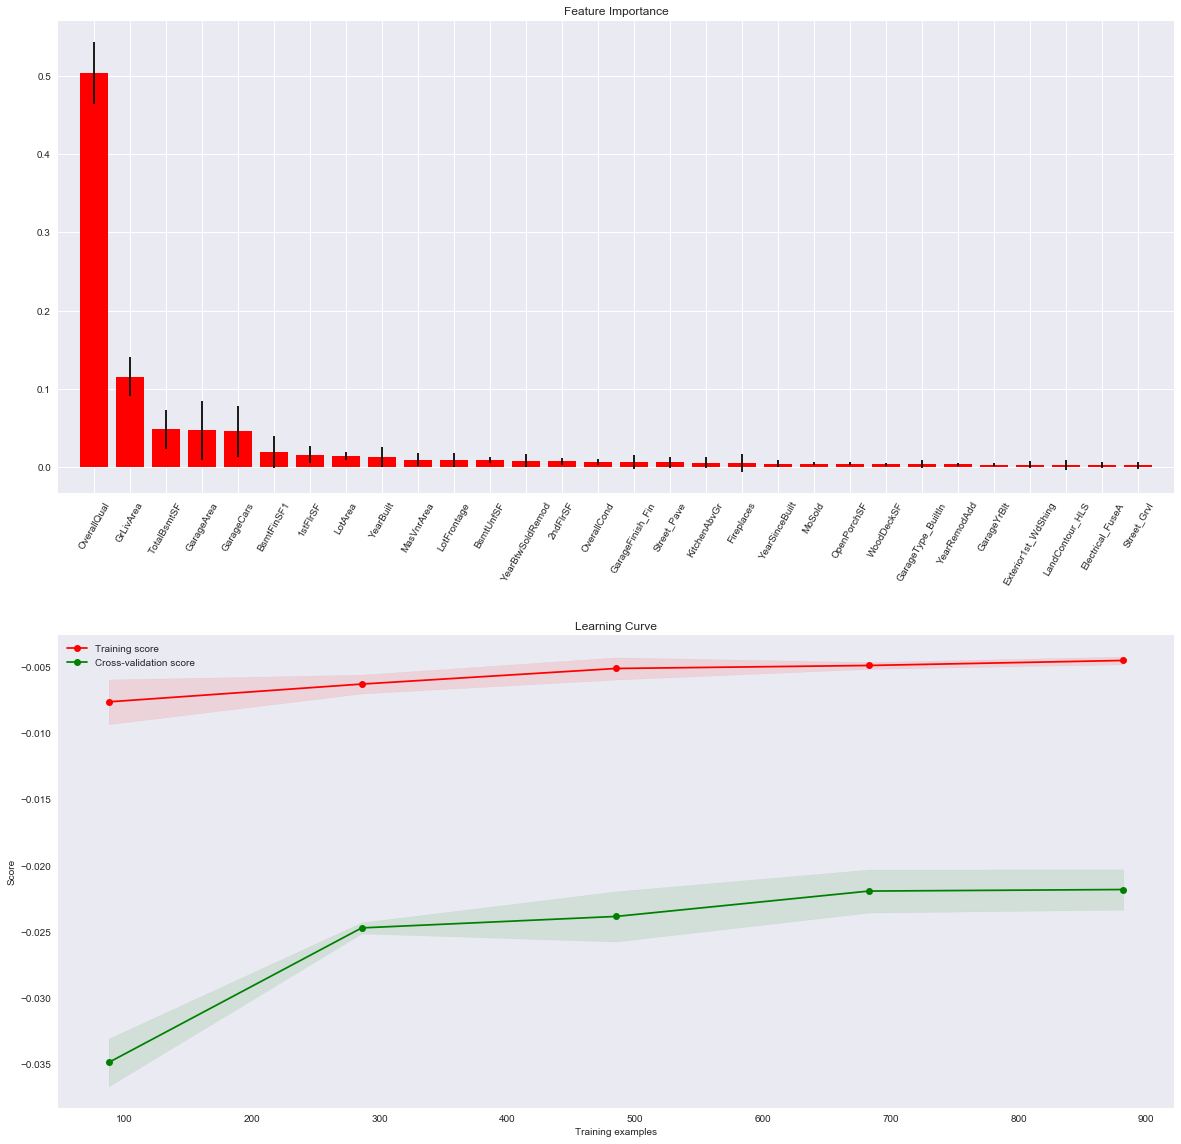

In [80]:
_, _ = measure_regression_model(forest_model_default, forest_scores_default, training_data, train_prepared, 
                                        "SalePrice", labels, features, scoring=scoring, outlier_pipeline=outlier_pipeline)

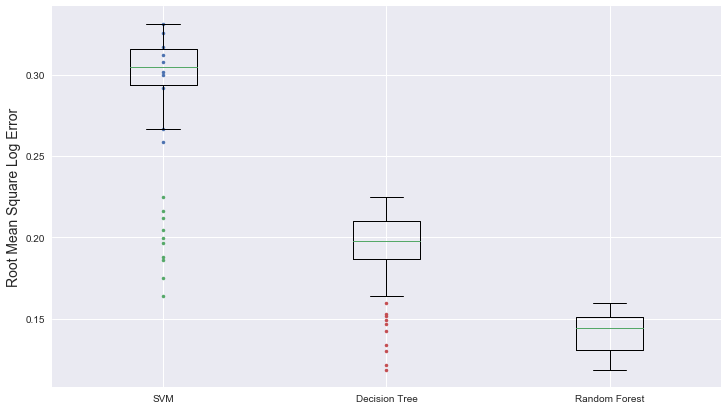

In [81]:
plt.figure(figsize=(12, 7))
plt.plot([1]*10, svr_scores, ".")
plt.plot([1]*10, tree_scores, ".")
plt.plot([2]*10, forest_scores_default, ".")
plt.boxplot([svr_scores, tree_scores, forest_scores_default], labels=("SVM", "Decision Tree", "Random Forest"))
plt.ylabel("Root Mean Square Log Error", fontsize=14)
plt.show()

# Feature Engineering

Now that we have a baseline for a variety of models, let's enhance the quality of our features.

In [82]:
train["HasEnclosedPorch"] = train["EnclosedPorch"] != 0
train[["HasEnclosedPorch", "SalePrice"]].groupby(['HasEnclosedPorch']).mean()

,SalePrice
HasEnclosedPorch,
False,186856.88099
True,145192.93750


In [83]:
train[["GrLivArea", "TotalBsmtSF", "GarageArea", "GarageCars", "BsmtFinSF1", "1stFlrSF", "LotArea", "MasVnrArea"]].describe()

,GrLivArea,TotalBsmtSF,GarageArea,GarageCars,BsmtFinSF1,1stFlrSF,LotArea,MasVnrArea
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000
mean,1515.463699,1057.429452,472.980137,1.767123,443.639726,1162.626712,10516.828082,103.685262
std,525.480383,438.705324,213.804841,0.747315,456.098091,386.587738,9981.264932,181.066207
min,334.000000,0.000000,0.000000,0.000000,0.000000,334.000000,1300.000000,0.000000
25%,1129.500000,795.750000,334.500000,1.000000,0.000000,882.000000,7553.500000,0.000000
50%,1464.000000,991.500000,480.000000,2.000000,383.500000,1087.000000,9478.500000,0.000000
75%,1776.750000,1298.250000,576.000000,2.000000,712.250000,1391.250000,11601.500000,166.000000
max,5642.000000,6110.000000,1418.000000,4.000000,5644.000000,4692.000000,215245.000000,1600.000000


In [84]:
train["GrLivAreaBucket"] = train["GrLivArea"] // 1000 * 1000
train[["GrLivAreaBucket", "SalePrice"]].groupby(['GrLivAreaBucket']).mean()

,SalePrice
GrLivAreaBucket,
0,112984.900433
1000,175006.447732
2000,272048.456853
3000,367900.000000
4000,561583.333333
5000,160000.000000


In [85]:
train["TotalBsmtSFBucket"] = train["TotalBsmtSF"] // 1000 * 1000
train[["TotalBsmtSFBucket", "SalePrice"]].groupby(['TotalBsmtSFBucket']).mean()

,SalePrice
TotalBsmtSFBucket,
0,144766.519515
1000,211286.664723
2000,385654.615385
3000,363437.500000
6000,160000.000000


In [86]:
train["GarageAreaBucket"] = train["GarageArea"] // 350 * 350
train[["GarageAreaBucket", "SalePrice"]].groupby(['GarageAreaBucket']).mean()

,SalePrice
GarageAreaBucket,
0,123388.772021
350,182559.078740
700,292250.373563
1050,321029.400000
1400,160000.000000


In [87]:
train["BsmtFinSF1Bucket"] = train["BsmtFinSF1"] // 400 * 400
train[["BsmtFinSF1Bucket", "SalePrice"]].groupby(['BsmtFinSF1Bucket']).mean()

,SalePrice
BsmtFinSF1Bucket,
0,163347.070856
400,167720.100719
800,208377.401042
1200,298439.977528
1600,375102.900000
2000,513802.333333
5600,160000.000000


Let's also remove outliers from BsmtFinSF1Bucket

In [88]:
train["1stFlrSFBucket"] = train["1stFlrSF"] // 800 * 800
train[["1stFlrSFBucket", "SalePrice"]].groupby(['1stFlrSFBucket']).mean()

,SalePrice
1stFlrSFBucket,
0,129780.151659
800,172319.982775
1600,271263.288660
2400,433984.250000
3200,430000.000000
4000,160000.000000


In [89]:
train["LotAreaBucket"] = train["LotArea"] // 20000 * 20000
train[["LotAreaBucket", "SalePrice"]].groupby(['LotAreaBucket']).mean()

,SalePrice
LotAreaBucket,
0,178171.181947
20000,241779.307692
40000,300718.750000
60000,220000.000000
100000,302000.000000
140000,277000.000000
160000,228950.000000
200000,375000.000000


In [90]:
train["MasVnrAreaBucket"] = train["MasVnrArea"] // 500 * 500
train[["MasVnrAreaBucket", "SalePrice"]].groupby(['MasVnrAreaBucket']).mean()

,SalePrice
MasVnrAreaBucket,
0.0,175419.189383
500.0,295705.725490
1000.0,399788.333333
1500.0,239000.000000


In [91]:
class SpecificFeaturesAdderRemover(BaseEstimator, TransformerMixin):
    def __init__(self, feature_adder_params, df_out=False):
        self.new_features_names = feature_adder_params["new_features_names"]
        self.features_to_remove = feature_adder_params["features_to_remove"]
        self.df_out = df_out
    def fit(self, X, y=None):
        self.new_features_names_ = self.new_features_names
        self.features_to_remove_ = self.features_to_remove
        self.original_df_columns_ = X.columns
        self.original_df_ = X
        return self  # nothing else to do
    def transform(self, X, y=None):
        X["HasRemod"] = X["YearBuilt"] != X["YearRemodAdd"] 
        X["YearSinceRemod"] = X["YearRemodAdd"] - X["YearBuilt"]
        X["YearSinceBuilt"] = X["YrSold"] -  X["YearBuilt"]
        X["YearBtwSoldRemod"] = X["YrSold"] - X["YearRemodAdd"]
        
        X["HasEnclosedPorch"] = X["EnclosedPorch"] != 0
        
        X["GrLivAreaBucket"] = X["GrLivArea"] // 1000 * 1000
        X["TotalBsmtSFBucket"] = X["TotalBsmtSF"] // 1000 * 1000
        X["GarageAreaBucket"] = X["GarageArea"] // 350 * 350
        X["BsmtFinSF1Bucket"] = X["BsmtFinSF1"] // 400 * 400
        X["1stFlrSFBucket"] = X["1stFlrSF"] // 800 * 800
        X["LotAreaBucket"] = X["LotArea"] // 20000 * 20000
        X["MasVnrAreaBucket"] = X["MasVnrArea"] // 500 * 500
        
        if self.features_to_remove is not None:           
            X = X.drop(self.features_to_remove_, axis=1)            
            
        if self.df_out:
            return X
        else:
            return np.c_[X]

In [92]:
outlier_params = {
    "features": ["SalePrice", "GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "LotArea", "BsmtFinSF1"], 
    "range": [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5], 
    "remove_lows": [True, True, True, True, True, True, True],
    "remove_highs": [True, True, True, True, True, True, True]
}

outlier_pipeline = Pipeline([  
        ("outlier_removal", OutlierRemover(outlier_params)),        
])

feature_adder_params = {
    "new_features_names": ["HasRemod", "YearSinceRemod", "YearSinceBuilt", "YearBtwSoldRemod", "HasEnclosedPorch", "GrLivAreaBucket", "TotalBsmtSFBucket", "GarageAreaBucket", "BsmtFinSF1Bucket", "1stFlrSFBucket", "LotAreaBucket", "MasVnrAreaBucket"],
    "features_to_remove": None
}

feature_add_remove_pipeline = Pipeline([
    (("add_features", SpecificFeaturesAdderRemover(feature_adder_params, df_out=True)))
])

feature_transform_params = {
    "features": ["MSSubClass", "GrLivAreaBucket", "TotalBsmtSFBucket", "GarageAreaBucket", "BsmtFinSF1Bucket", "1stFlrSFBucket", "LotAreaBucket", "MasVnrAreaBucket"],
    "transforms": ['object', 'object', 'object', 'object', 'object', 'object', 'object', 'object'],
    "is_type_change": [True, True, True, True, True, True, True, True]
}

feature_transform_pipeline = Pipeline([
    (("transform_features", FeatureTransformer(feature_transform_params, df_out=True)))
])


num_pipelines = []
num_pipelines.append(('inf_imputer', InfImputer()))
num_pipelines.append(('num_imputer', Imputer(strategy="median")))
num_pipelines.append(('std_scaler', StandardScaler()))

na_dict = {
    "Alley": "No Alley Access",
    "MasVnrType": "None",
    "BsmtQual": "No Basement",
    "BsmtCond": "No Basement",
    "BsmtExposure": "No Basement",
    "BsmtFinType1": "No Basement",
    "BsmtFinType2": "No Basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None"
}

cat_pipelines = []

cat_pipelines.append(("apply_na", AddLevelImputer(na_dict, df_out=True)))
cat_pipelines.append(("cat_imputer", MostFrequentImputer()))
cat_pipelines.append(("cat_encoder", OneHotEncoder(sparse=False)))

bool_pipelines = []
bool_pipelines.append(("bool_imputer", MostFrequentImputer()))
bool_pipelines.append(("bool_encoder", OneHotEncoder(sparse=False)))

identifiers_to_drop = ["Id", "source"]

In [93]:
training_data = train.copy()

In [94]:

forest_model_new_features, train_prepared, labels, features, forest_scores_new_features = build_run_model(RandomForestRegressor(random_state=42), training_data, "SalePrice", 
                                                                                                                  num_pipelines, cat_pipelines, bool_pipelines, identifiers_to_drop, scoring=scoring, 
                                                                                feature_add_remove_pipeline=feature_add_remove_pipeline, feature_transform_pipeline=feature_transform_pipeline, 
                                                                                outlier_pipeline=outlier_pipeline, feature_list=None)




Removing features: ['Id', 'source']

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...

CV complete




Model Report:

CV Score : Mean - 0.138895 | Std - 0.014027 | Min - 0.120896 | Max - 0.158216


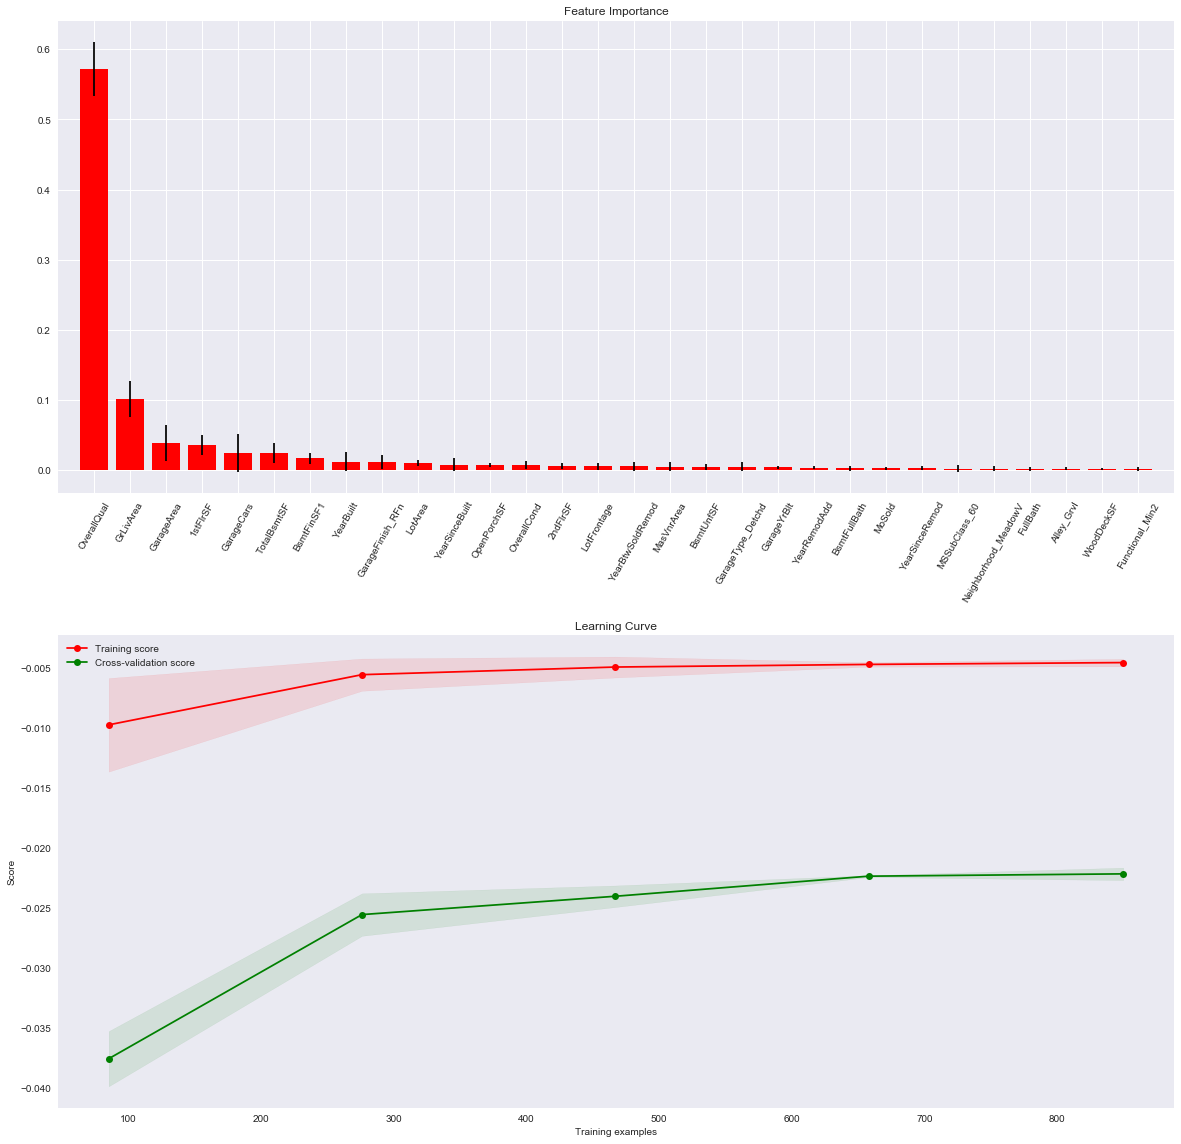

In [95]:
feature_importances_forest_new_features, feature_names_forest_new_features = measure_regression_model(forest_model_new_features, forest_scores_new_features, training_data, train_prepared, 
                                        "SalePrice", labels, features, scoring=scoring, outlier_pipeline=outlier_pipeline)

Let's try removing some of the original features

In [96]:
outlier_params = {
    "features": ["SalePrice", "GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "LotArea", "BsmtFinSF1"], 
    "range": [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5], 
    "remove_lows": [True, True, True, True, True, True, True],
    "remove_highs": [True, True, True, True, True, True, True]
}

outlier_pipeline = Pipeline([  
        ("outlier_removal", OutlierRemover(outlier_params)),        
])

feature_adder_params = {
    "new_features_names": ["HasRemod", "YearSinceRemod", "YearSinceBuilt", "YearBtwSoldRemod", "HasEnclosedPorch", "GrLivAreaBucket", "TotalBsmtSFBucket", "GarageAreaBucket", "BsmtFinSF1Bucket", "1stFlrSFBucket", "LotAreaBucket", "MasVnrAreaBucket"],
    "features_to_remove": ["GrLivArea", "TotalBsmtSF", "GarageArea", "GarageCars", "BsmtFinSF1", "1stFlrSF", "LotArea", "MasVnrArea"]
}

feature_add_remove_pipeline = Pipeline([
    (("add_features", SpecificFeaturesAdderRemover(feature_adder_params, df_out=True)))
])

feature_transform_params = {
    "features": ["MSSubClass", "GrLivAreaBucket", "TotalBsmtSFBucket", "GarageAreaBucket", "BsmtFinSF1Bucket", "1stFlrSFBucket", "LotAreaBucket", "MasVnrAreaBucket"],
    "transforms": ['object', 'object', 'object', 'object', 'object', 'object', 'object', 'object'],
    "is_type_change": [True, True, True, True, True, True, True, True]
}

feature_transform_pipeline = Pipeline([
    (("transform_features", FeatureTransformer(feature_transform_params, df_out=True)))
])


num_pipelines = []
num_pipelines.append(('inf_imputer', InfImputer()))
num_pipelines.append(('num_imputer', Imputer(strategy="median")))
num_pipelines.append(('std_scaler', StandardScaler()))

na_dict = {
    "Alley": "No Alley Access",
    "MasVnrType": "None",
    "BsmtQual": "No Basement",
    "BsmtCond": "No Basement",
    "BsmtExposure": "No Basement",
    "BsmtFinType1": "No Basement",
    "BsmtFinType2": "No Basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None"
}

cat_pipelines = []

cat_pipelines.append(("apply_na", AddLevelImputer(na_dict, df_out=True)))
cat_pipelines.append(("cat_imputer", MostFrequentImputer()))
cat_pipelines.append(("cat_encoder", OneHotEncoder(sparse=False)))

bool_pipelines = []
bool_pipelines.append(("bool_imputer", MostFrequentImputer()))
bool_pipelines.append(("bool_encoder", OneHotEncoder(sparse=False)))

identifiers_to_drop = ["Id", "source"]

In [97]:
training_data = train.copy()

In [98]:

forest_model_orig_features_removed, train_prepared, labels, features, forest_scores_orig_feat_removed = build_run_model(RandomForestRegressor(random_state=42), training_data, "SalePrice", 
                                                                                                                  num_pipelines, cat_pipelines, bool_pipelines, identifiers_to_drop, scoring=scoring, 
                                                                                feature_add_remove_pipeline=feature_add_remove_pipeline, feature_transform_pipeline=feature_transform_pipeline, 
                                                                                outlier_pipeline=outlier_pipeline, feature_list=None)




Removing features: ['Id', 'source']

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...

CV complete




Model Report:

CV Score : Mean - 0.148951 | Std - 0.014923 | Min - 0.129269 | Max - 0.173706


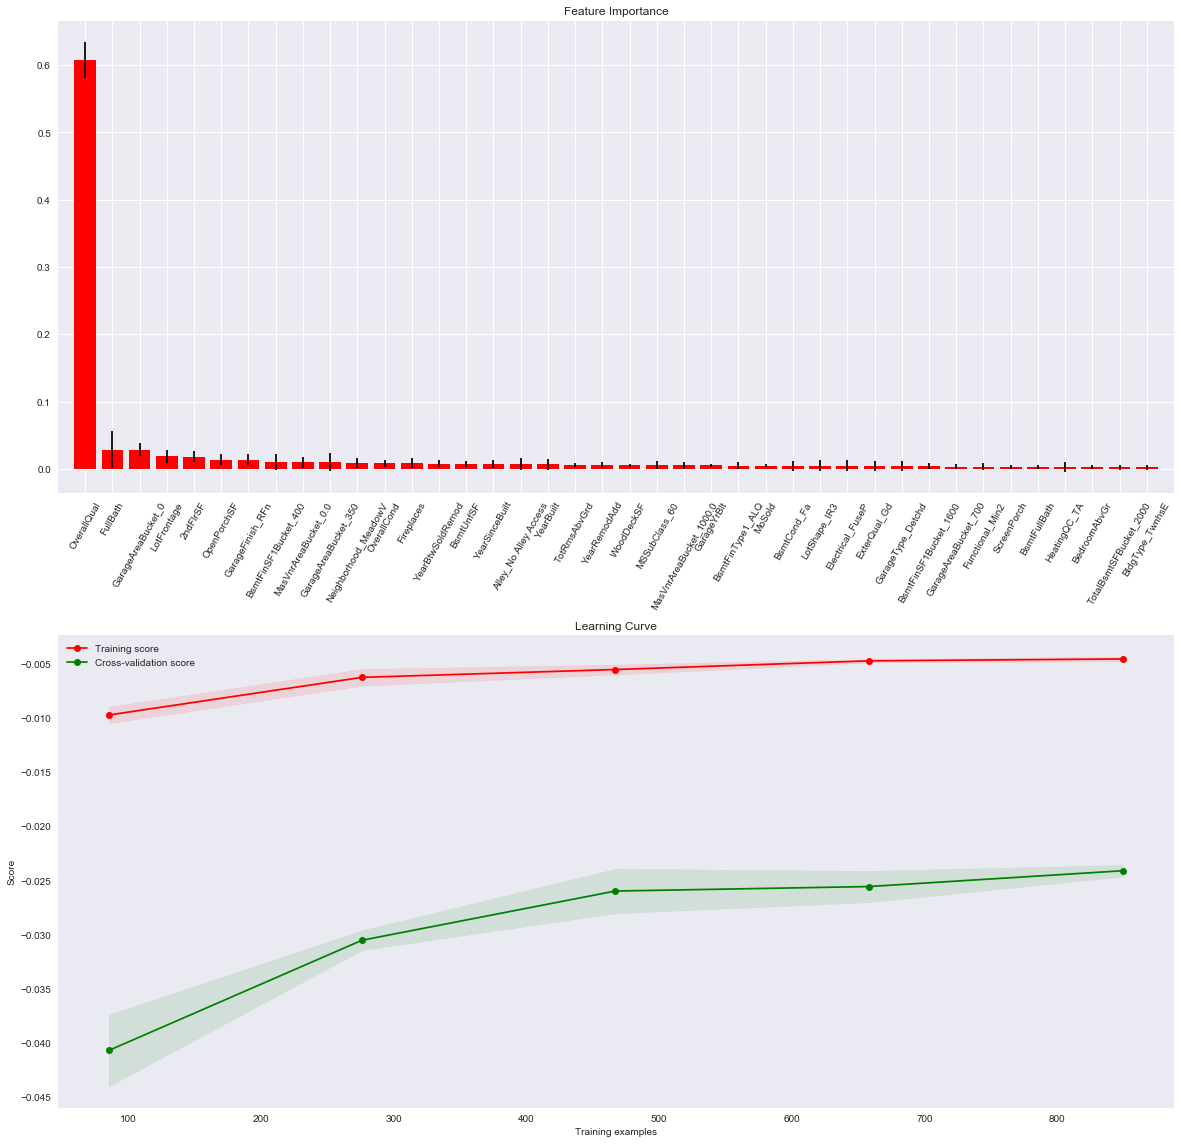

In [99]:
_, _ = measure_regression_model(forest_model_orig_features_removed, forest_scores_orig_feat_removed, training_data, train_prepared, 
                                        "SalePrice", labels, features, scoring=scoring, outlier_pipeline=outlier_pipeline, max_num_features=40)

Ok looks like we score better by keeping all the source features. Let's keep all the source feature but remove the least important ones. 

In [100]:
outlier_params = {
    "features": ["SalePrice", "GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "LotArea", "BsmtFinSF1"], 
    "range": [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5], 
    "remove_lows": [True, True, True, True, True, True, True],
    "remove_highs": [True, True, True, True, True, True, True]
}

outlier_pipeline = Pipeline([  
        ("outlier_removal", OutlierRemover(outlier_params)),        
])

feature_adder_params = {
    "new_features_names": ["HasRemod", "YearSinceRemod", "YearSinceBuilt", "YearBtwSoldRemod", "HasEnclosedPorch", "GrLivAreaBucket", "TotalBsmtSFBucket", "GarageAreaBucket", "BsmtFinSF1Bucket", "1stFlrSFBucket", "LotAreaBucket", "MasVnrAreaBucket"],
    "features_to_remove": None
}

feature_add_remove_pipeline = Pipeline([
    (("add_features", SpecificFeaturesAdderRemover(feature_adder_params, df_out=True)))
])

feature_transform_params = {
    "features": ["MSSubClass", "GrLivAreaBucket", "TotalBsmtSFBucket", "GarageAreaBucket", "BsmtFinSF1Bucket", "1stFlrSFBucket", "LotAreaBucket", "MasVnrAreaBucket"],
    "transforms": ['object', 'object', 'object', 'object', 'object', 'object', 'object', 'object'],
    "is_type_change": [True, True, True, True, True, True, True, True]
}

feature_transform_pipeline = Pipeline([
    (("transform_features", FeatureTransformer(feature_transform_params, df_out=True)))
])


num_pipelines = []
num_pipelines.append(('inf_imputer', InfImputer()))
num_pipelines.append(('num_imputer', Imputer(strategy="median")))
num_pipelines.append(('std_scaler', StandardScaler()))

na_dict = {
    "Alley": "No Alley Access",
    "MasVnrType": "None",
    "BsmtQual": "No Basement",
    "BsmtCond": "No Basement",
    "BsmtExposure": "No Basement",
    "BsmtFinType1": "No Basement",
    "BsmtFinType2": "No Basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None"
}

cat_pipelines = []

cat_pipelines.append(("apply_na", AddLevelImputer(na_dict, df_out=True)))
cat_pipelines.append(("cat_imputer", MostFrequentImputer()))
cat_pipelines.append(("cat_encoder", OneHotEncoder(sparse=False)))

bool_pipelines = []
bool_pipelines.append(("bool_imputer", MostFrequentImputer()))
bool_pipelines.append(("bool_encoder", OneHotEncoder(sparse=False)))

identifiers_to_drop = ["Id", "source"]

In [108]:
training_data = train.copy()

In [109]:
forest_model_top_features, train_prepared, labels, features, forest_scores_top_features = build_run_model(RandomForestRegressor(random_state=42), training_data, "SalePrice", 
                                                                                                                  num_pipelines, cat_pipelines, bool_pipelines, identifiers_to_drop, scoring=scoring, 
                                                                                feature_add_remove_pipeline=feature_add_remove_pipeline, feature_transform_pipeline=feature_transform_pipeline, 
                                                                                outlier_pipeline=outlier_pipeline, feature_list=feature_importances_forest_new_features, num_important_features=15)




Removing features: ['Id', 'source']

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...

CV complete




Model Report:

CV Score : Mean - 0.142564 | Std - 0.012475 | Min - 0.124124 | Max - 0.164575


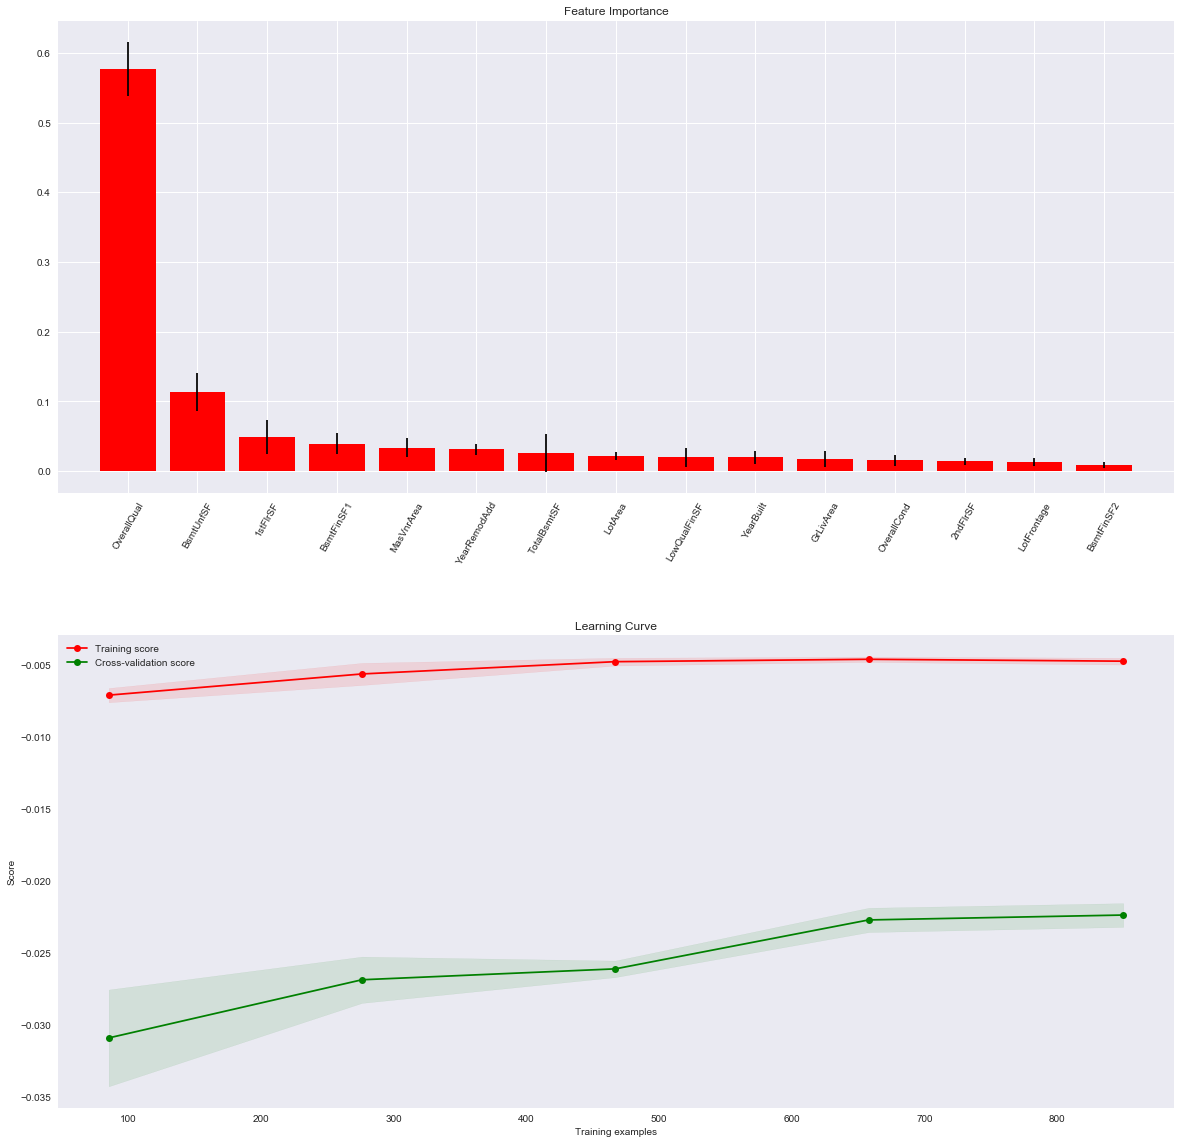

In [110]:
_,_ = measure_regression_model(forest_model_top_features, forest_scores_top_features, training_data, train_prepared, 
                                        "SalePrice", labels, features, scoring=scoring, outlier_pipeline=outlier_pipeline, max_num_features=40)